In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.io import arff
from sklearn import cluster
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

-------------------------------------------
Affichage données standardisées            


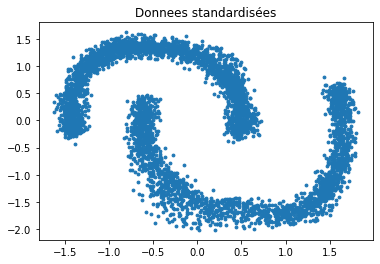

In [30]:
path = './artificial/'
databrut = arff.loadarff(open(path+"banana.arff", 'r'))
data = [[x[0],x[1]] for x in databrut[0]]
datanp = np.array([[x[0],x[1]] for x in databrut[0]])


########################################################################
# Preprocessing: standardization of data
########################################################################

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(datanp)

data_scaled = scaler.transform(datanp)

import scipy.cluster.hierarchy as shc

print("-------------------------------------------")
print("Affichage données standardisées            ")
f0_scaled = data_scaled[:,0] # tous les élements de la première colonne
f1_scaled = data_scaled[:,1] # tous les éléments de la deuxième colonne
#print(f0)
#print(f1)

plt.scatter(f0_scaled, f1_scaled, s=8)
plt.title("Donnees standardisées")
plt.show()


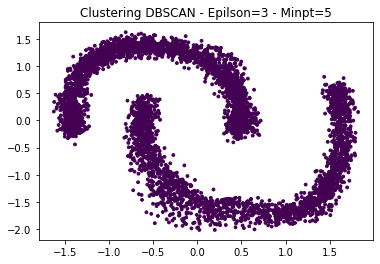

In [31]:
########################################################################
# Run DBSCAN clustering method 
# for a given number of parameters eps and min_samples
#  
distance=3
min_pts=5
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)

# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=3 - Minpt=5")
plt.show()

In [32]:
len(databrut[0][0])

3

In [33]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


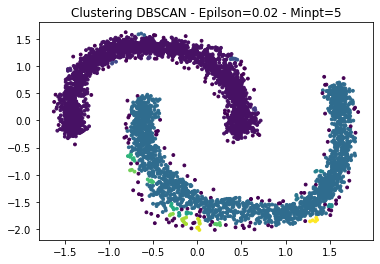

Estimated number of clusters: 23
Estimated number of noise points: 152


In [34]:
# Another example
distance=0.01
min_pts=3
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)
# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=0.02 - Minpt=5")
plt.show()
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


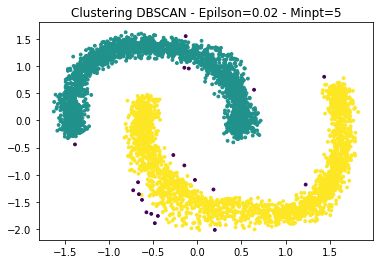

In [35]:
# Another example
distance=0.02
min_pts=5
cl_pred = cluster.DBSCAN(eps=distance, min_samples=min_pts).fit_predict(data)

# Plot results
plt.scatter(f0_scaled, f1_scaled, c=cl_pred, s=8)
plt.title("Clustering DBSCAN - Epilson=0.02 - Minpt=5")
plt.show()

In [36]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
n_noise_ = list(cl_pred).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 2
Estimated number of noise points: 20


In [37]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)

In [38]:
distances, indices = nbrs.kneighbors(data)

In [39]:
distances

array([[0.        , 0.        ],
       [0.        , 0.002     ],
       [0.        , 0.002     ],
       ...,
       [0.        , 0.00824621],
       [0.        , 0.00860233],
       [0.        , 0.00412311]])

In [40]:
sort_distance=np.sort(distances[:,1])

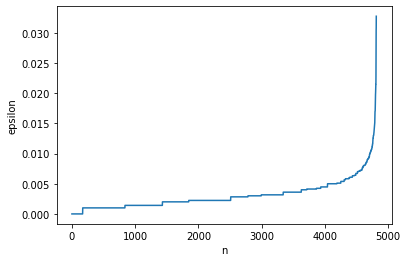

In [41]:
plt.plot(np.arange(len(sort_distance))+1, sort_distance)
plt.xlabel("n")
plt.ylabel("epsilon")
plt.show()

In [165]:
from sklearn import metrics
import time
from collections import Counter
from random import randint
from sklearn.metrics import davies_bouldin_score


#We want to determine the optimal epsilon and min_points for finding clusters
def bestConfigDBSCAN(file, params_min_pts={"n":5, "min":1, "max":50}, 
                params_eps={"n":5, "window":0.1, "center":1}, cluster_filter=-1):
    
    
    databrut = arff.loadarff(open(file, 'r'))

    
    #With the last column is labels
    datanp = np.array([x.tolist()[0:-1] for x in databrut[0]])
    
    plt.scatter(datanp[:,0], datanp[:,1], s=8)
    plt.title("Donnees initiales")
    plt.show()
    
    #Stadardization
    scaler = preprocessing.StandardScaler().fit(datanp)
    data_scaled=scaler.transform(datanp)

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data_scaled)
    distances, indices = nbrs.kneighbors(data_scaled)
    
    sort_distance=np.sort(distances[:,1])
    
    plt.plot(np.arange(len(sort_distance))+1, sort_distance)
    plt.xlabel("n")
    plt.ylabel("epsilon")
    plt.title("Fonction de répartition")
    plt.show()
    
    max_distance=sort_distance[-1]
    min_distance=sort_distance[0]
    
    print(f"Distance minimale entre un échantillon et son premier voisin : {min_distance} ")
    print(f"Distance maximale entre un échantillon et son premier voisin : {max_distance} ")

    EPS={}
    MIN_POINTS=np.linspace(params_min_pts["min"], params_min_pts["max"], params_min_pts["n"])
    #EPS=np.linspace(params_eps["window_inf"]*max_distance, params_eps['window_sup']*max_distance, params_eps["n"])
    METRICS=['euclidean', 'l1', 'l2', 'manhattan','cityblock']
    
    print(f"Paramètres 'min_pts' testés : {MIN_POINTS}")
    #print(f"Paramètres 'epsilon' testés : {EPS}")
    
    
    l=params_eps.get("n")
    m=len(MIN_POINTS)
    n=len(METRICS)
   
    
    eval_params={}
    
    eval_params['CAL']=np.zeros((l, m, n))
    eval_params['SILH']=np.zeros((l, m, n))
    eval_params['TIME']=np.zeros((l, m, n))
    eval_params['DB']=np.zeros((l, m, n))
    
    
    #Nombre de clusters
    K=np.zeros((l,m,n))
    for i_metric, v_metric in enumerate(METRICS):
        
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric=v_metric).fit(data_scaled)
        distances, indices = nbrs.kneighbors(data_scaled)

        sort_distance=np.sort(distances[:,1])

        plt.plot(np.arange(len(sort_distance))+1, sort_distance)
        plt.xlabel("n")
        plt.ylabel("epsilon")
        plt.title(f"Fonction de répartition - metric : {v_metric}")
        plt.show()

        max_distance=sort_distance[-1]
        min_distance=sort_distance[0]
        
        center_eps=sort_distance[round(len(sort_distance)*params_eps['center'])-1]

        print(f"########## METRIC - {v_metric} - ##############")
        print(f"Distance minimale entre un échantillon et son premier voisin : {min_distance} ")
        print(f"Distance maximale entre un échantillon et son premier voisin : {max_distance} ")
              
        EPS[v_metric]=np.linspace(center_eps-center_eps*params_eps['window'], center_eps+center_eps*params_eps['window'], params_eps["n"])
        print(EPS[v_metric])
        
        
        
        for i_eps, v_eps in enumerate(EPS[v_metric]):
            
            
            for i_minpts, v_minpts in enumerate(MIN_POINTS):
                
                test=False
                
                tps1 = time.time()
                cl_pred = cluster.DBSCAN(eps=v_eps, min_samples=v_minpts, metric=v_metric).fit_predict(data_scaled)
                tps2 = time.time()
                time
                n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)


                #If there is not enough cluster predicted
                silh=-10000
                cal=-10000
                DB=10000
                
                if (n_clusters_==cluster_filter):
                    test=True
                

                if (len(set(cl_pred))>1) and (cluster_filter==-1 or test==True):
                    silh=metrics.silhouette_score(data_scaled, cl_pred)
                    cal=metrics.calinski_harabasz_score(data_scaled, cl_pred)
                    DB=davies_bouldin_score(data_scaled, cl_pred)


                t=tps2-tps1

                eval_params['SILH'][i_eps, i_minpts, i_metric]=silh
                eval_params['CAL'][i_eps, i_minpts, i_metric]=cal
                eval_params['DB'][i_eps, i_minpts, i_metric]=DB
                eval_params['TIME'][i_eps, i_minpts, i_metric]=t        


                print(f"silhouette : {silh}, calinski : {cal}, DB : {DB}, time : {t}, clusters : {n_clusters_}")
        
            
            
     #Find params that optimize metrics
    best_params={}
    best_params['CAL']=np.where(eval_params['CAL']==np.max(eval_params['CAL']))
    best_params['SILH']=np.where(eval_params['SILH']==np.max(eval_params['SILH']))
    best_params['DB']=np.where(eval_params['DB']==np.min(eval_params['DB']))
    
  
    return eval_params, best_params, EPS
            
            




    

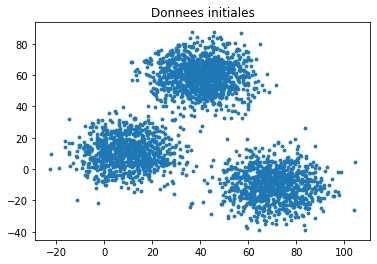

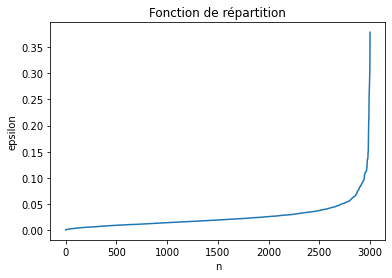

Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


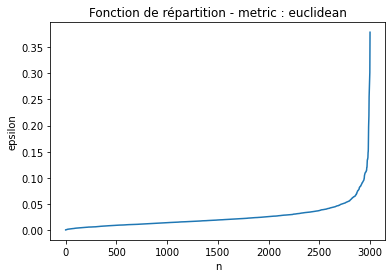

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.05864348 0.06190145 0.06515942 0.0684174  0.07167537]
silhouette : -0.29534431650760834, calinski : 133.25251471441618, DB : 0.48503315292125365, time : 0.008016586303710938, clusters : 316
silhouette : -0.3370236775178017, calinski : 229.73413688483157, DB : 1.200461342315513, time : 0.012019634246826172, clusters : 32
silhouette : -0.3951617816158893, calinski : 112.8740901066983, DB : 1.1901888823280706, time : 0.010840177536010742, clusters : 34
silhouette : -0.38121320939878645, calinski : 80.70407014675669, DB : 1.1619533116384537, time : 0.007421731948852539, clusters : 22
silhouette : -0.5310112229367862, calinski : 54.3547390928711, DB : 1.1136114468491805, time : 0.007125139236450195, clusters : 17
silhouette : -0.2604672774210593, calinski : 133.49097870418956

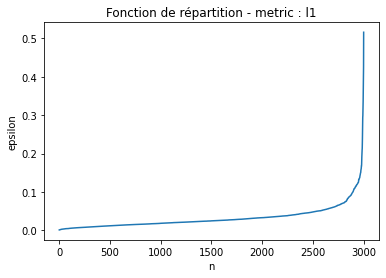

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.07668715 0.08094755 0.08520794 0.08946834 0.09372874]
silhouette : -0.2685803329472509, calinski : 132.97320705863788, DB : 0.4853722137482625, time : 0.014276504516601562, clusters : 273
silhouette : -0.3069080253077213, calinski : 301.5697831081, DB : 1.2519730013602461, time : 0.012562990188598633, clusters : 27
silhouette : -0.3630155250990839, calinski : 152.84597766256087, DB : 1.1589325021779744, time : 0.008423328399658203, clusters : 29
silhouette : -0.38000105286770713, calinski : 127.70239486031222, DB : 1.2057228269216453, time : 0.008381366729736328, clusters : 16
silhouette : -0.43345506389646804, calinski : 68.79725001380679, DB : 1.1608416189696196, time : 0.01002955436706543, clusters : 18
silhouette : -0.27913079742043895, calinski : 133.8146199542128, DB : 0.48

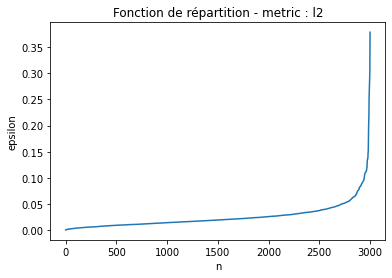

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.05864348 0.06190145 0.06515942 0.0684174  0.07167537]
silhouette : -0.29534431650760834, calinski : 133.25251471441618, DB : 0.48503315292125365, time : 0.008808612823486328, clusters : 316
silhouette : -0.3370236775178017, calinski : 229.73413688483157, DB : 1.200461342315513, time : 0.010980606079101562, clusters : 32
silhouette : -0.3951617816158893, calinski : 112.8740901066983, DB : 1.1901888823280706, time : 0.00743412971496582, clusters : 34
silhouette : -0.38121320939878645, calinski : 80.70407014675669, DB : 1.1619533116384537, time : 0.00726771354675293, clusters : 22
silhouette : -0.5310112229367862, calinski : 54.3547390928711, DB : 1.1136114468491805, time : 0.007858037948608398, clusters : 17
silhouette : -0.2604672774210593, calinski : 133.49097870418956, DB : 0.

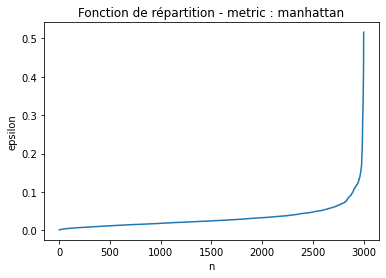

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.07668715 0.08094755 0.08520794 0.08946834 0.09372874]
silhouette : -0.2685803329472509, calinski : 132.97320705863788, DB : 0.4853722137482625, time : 0.012442827224731445, clusters : 273
silhouette : -0.3069080253077213, calinski : 301.5697831081, DB : 1.2519730013602461, time : 0.012398481369018555, clusters : 27
silhouette : -0.3630155250990839, calinski : 152.84597766256087, DB : 1.1589325021779744, time : 0.012253761291503906, clusters : 29
silhouette : -0.38000105286770713, calinski : 127.70239486031222, DB : 1.2057228269216453, time : 0.0119781494140625, clusters : 16
silhouette : -0.43345506389646804, calinski : 68.79725001380679, DB : 1.1608416189696196, time : 0.011862993240356445, clusters : 18
silhouette : -0.27913079742043895, calinski : 133.8146199542128, DB 

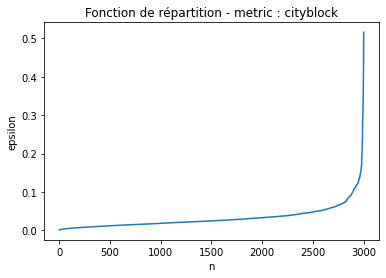

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.07668715 0.08094755 0.08520794 0.08946834 0.09372874]
silhouette : -0.2685803329472509, calinski : 132.97320705863788, DB : 0.4853722137482625, time : 0.011116743087768555, clusters : 273
silhouette : -0.3069080253077213, calinski : 301.5697831081, DB : 1.2519730013602461, time : 0.014341354370117188, clusters : 27
silhouette : -0.3630155250990839, calinski : 152.84597766256087, DB : 1.1589325021779744, time : 0.015038013458251953, clusters : 29
silhouette : -0.38000105286770713, calinski : 127.70239486031222, DB : 1.2057228269216453, time : 0.01534414291381836, clusters : 16
silhouette : -0.43345506389646804, calinski : 68.79725001380679, DB : 1.1608416189696196, time : 0.011473417282104492, clusters : 18
silhouette : -0.27913079742043895, calinski : 133.8146199542128, DB

In [166]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"xclara.arff", params_eps={"n":5, "window":0.1, "center":0.95},
                                              params_min_pts={"n":5, "min":1,"max":15})

In [167]:
best_params

{'CAL': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'DB': (array([3, 3]), array([0, 0]), array([0, 2]))}

In [75]:
EPS

{'euclidean': array([0.05864348, 0.06190145, 0.06515942, 0.0684174 , 0.07167537]),
 'l1': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874]),
 'l2': array([0.05864348, 0.06190145, 0.06515942, 0.0684174 , 0.07167537]),
 'manhattan': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874]),
 'cityblock': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874])}

Nous observons un grand nombre de combinaisons ayant des performances similaires selon les métriques Ue nous choisissons. Une analyse temporelle peut également être réalisée (même nécessaire pour départager les combinaisons. 
Concernant les meilleures combinaison communes (en fonction du coefficient de silhouette et de calinski, nous retrouvons (2, 0), (2, 1), etc...
C'est à dire : 
eps = 0.17793745
min_pts = 1

In [76]:
def doDBSCAN(file, eps, min_pts, metric):
    
    databrut = arff.loadarff(open(file, 'r'))

    
    #With the last column is true labels
    datanp = np.array([x.tolist()[0:-1] for x in databrut[0]])
    
    #Stadardization
    scaler = preprocessing.StandardScaler().fit(datanp)
    data_scaled=scaler.transform(datanp)
    
    t1=time.time()
    cl_pred = cluster.DBSCAN(eps=eps, min_samples=min_pts, metric=metric).fit_predict(data_scaled)
    t2=time.time()

    # Plot results
    plt.scatter(data_scaled[:,0], data_scaled[:,1], c=cl_pred, s=8)
    plt.title(f"Clustering DBSCAN - Epilson={eps} - Minpt={min_pts} - Metric={metric}")
    plt.show()
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(cl_pred)) - (1 if -1 in cl_pred else 0)
    n_noise_ = list(cl_pred).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    silh=-1000
    cal=-1000
    DB=10000
    
    if (len(set(cl_pred))>1):
        silh=metrics.silhouette_score(data_scaled, cl_pred)
        cal=metrics.calinski_harabasz_score(data_scaled, cl_pred)
        DB=davies_bouldin_score(data_scaled, cl_pred)

    
    print('coefficient de silhouette: %f' % silh)
    print('coefficient de calinsky: %f' % cal)
    print('coefficient de Davies Bouldin: %f' % DB)
    print('Running time: %f' % (t2-t1))

    

In [77]:
best_params

{'CAL': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'DB': (array([3, 3]), array([0, 0]), array([0, 2]))}

In [78]:
EPS

{'euclidean': array([0.05864348, 0.06190145, 0.06515942, 0.0684174 , 0.07167537]),
 'l1': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874]),
 'l2': array([0.05864348, 0.06190145, 0.06515942, 0.0684174 , 0.07167537]),
 'manhattan': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874]),
 'cityblock': array([0.07668715, 0.08094755, 0.08520794, 0.08946834, 0.09372874])}

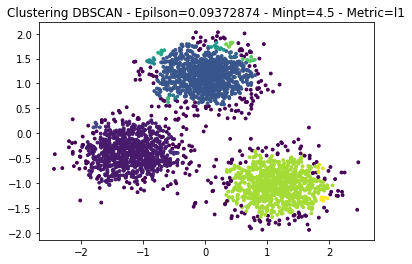

Estimated number of clusters: 15
Estimated number of noise points: 341
coefficient de silhouette: -0.041486
coefficient de calinsky: 748.116884
coefficient de Davies Bouldin: 1.145818
Running time: 0.010802


In [79]:
doDBSCAN(path+"xclara.arff",0.09372874,4.5,'l1')

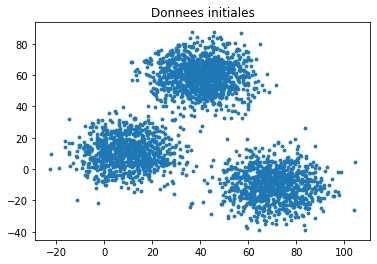

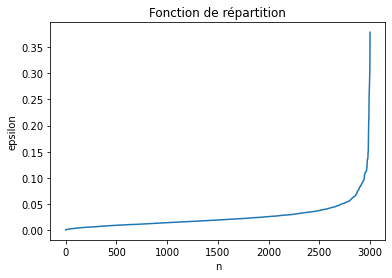

Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


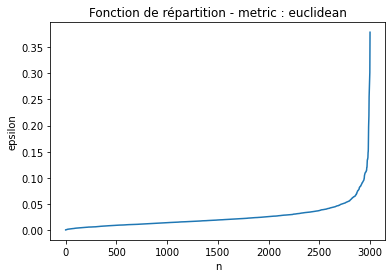

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.34015967 0.35905743 0.37795518 0.39685294 0.4157507 ]
silhouette : 0.046301599230154734, calinski : 3.5683224303249372, DB : 0.5310062076762069, time : 0.031226634979248047, clusters : 3
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.019098758697509766, clusters : 1
silhouette : 0.33211244903567455, calinski : 3.411428528256827, DB : 2.256458733730438, time : 0.02044677734375, clusters : 1
silhouette : 0.19488479862876906, calinski : 5.365980623335885, DB : 2.319419686098998, time : 0.02112293243408203, clusters : 1
silhouette : 0.19488479862876906, calinski : 5.365980623335885, DB : 2.319419686098998, time : 0.028362274169921875, clusters : 1
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913

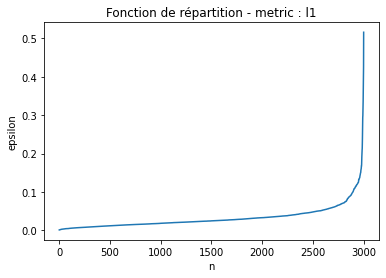

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.46425782 0.49004993 0.51584203 0.54163413 0.56742623]
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.03130960464477539, clusters : 2
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.02641892433166504, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.03205275535583496, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.02810359001159668, clusters : 1
silhouette : 0.20393577188417528, calinski : 5.508658041683649, DB : 2.0405176272546455, time : 0.031122922897338867, clusters : 1
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.471109134584872

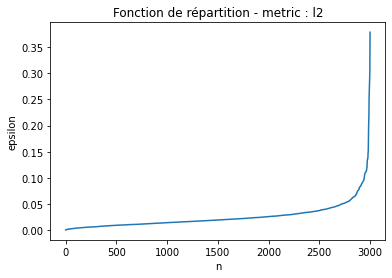

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.34015967 0.35905743 0.37795518 0.39685294 0.4157507 ]
silhouette : 0.046301599230154734, calinski : 3.5683224303249372, DB : 0.5310062076762069, time : 0.025563478469848633, clusters : 3
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.01819920539855957, clusters : 1
silhouette : 0.33211244903567455, calinski : 3.411428528256827, DB : 2.256458733730438, time : 0.01984858512878418, clusters : 1
silhouette : 0.19488479862876906, calinski : 5.365980623335885, DB : 2.319419686098998, time : 0.01856684684753418, clusters : 1
silhouette : 0.19488479862876906, calinski : 5.365980623335885, DB : 2.319419686098998, time : 0.021323680877685547, clusters : 1
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.4711091345848

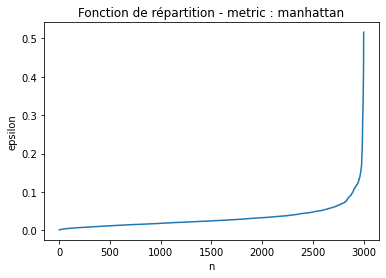

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.46425782 0.49004993 0.51584203 0.54163413 0.56742623]
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.025758028030395508, clusters : 2
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.023178815841674805, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.027977466583251953, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.024914026260375977, clusters : 1
silhouette : 0.20393577188417528, calinski : 5.508658041683649, DB : 2.0405176272546455, time : 0.027361392974853516, clusters : 1
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.4711

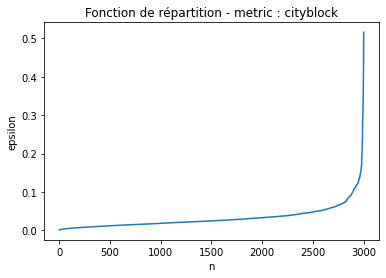

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.46425782 0.49004993 0.51584203 0.54163413 0.56742623]
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.02577376365661621, clusters : 2
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913458487297, time : 0.02601480484008789, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.025154829025268555, clusters : 1
silhouette : 0.35001344093030595, calinski : 2.132115721726655, DB : 2.4626142129114514, time : 0.02584099769592285, clusters : 1
silhouette : 0.20393577188417528, calinski : 5.508658041683649, DB : 2.0405176272546455, time : 0.02447032928466797, clusters : 1
silhouette : 0.3028430048266331, calinski : 4.183306327721479, DB : 0.47110913

In [80]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"xclara.arff", params_eps={"n":5, "window":0.1, "center":1},
                                              params_min_pts={"n":5, "min":1,"max":15})

In [81]:
best_params

{'CAL': (array([0, 0, 0]), array([4, 4, 4]), array([1, 3, 4])),
 'SILH': (array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 2]),
  array([1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 1, 1,
         2, 2, 3, 3]),
  array([0, 2, 1, 3, 4, 1, 3, 4, 0, 2, 0, 2, 0, 1, 2, 3, 4, 1, 3, 4, 0, 2,
         0, 2, 0, 2])),
 'DB': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]),
  array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0]),
  array([1, 3, 4, 1, 3, 4, 0, 1, 2, 3, 4, 1, 3, 4, 1, 3, 4, 0, 2]))}

In [82]:
EPS

{'euclidean': array([0.34015967, 0.35905743, 0.37795518, 0.39685294, 0.4157507 ]),
 'l1': array([0.46425782, 0.49004993, 0.51584203, 0.54163413, 0.56742623]),
 'l2': array([0.34015967, 0.35905743, 0.37795518, 0.39685294, 0.4157507 ]),
 'manhattan': array([0.46425782, 0.49004993, 0.51584203, 0.54163413, 0.56742623]),
 'cityblock': array([0.46425782, 0.49004993, 0.51584203, 0.54163413, 0.56742623])}

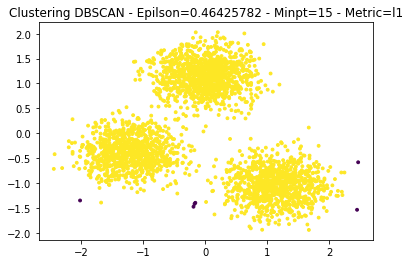

Estimated number of clusters: 1
Estimated number of noise points: 6
coefficient de silhouette: 0.203936
coefficient de calinsky: 5.508658
coefficient de Davies Bouldin: 2.040518
Running time: 0.027368


In [83]:
doDBSCAN(path+"xclara.arff",0.46425782,15,'l1')

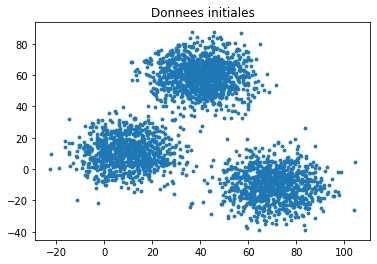

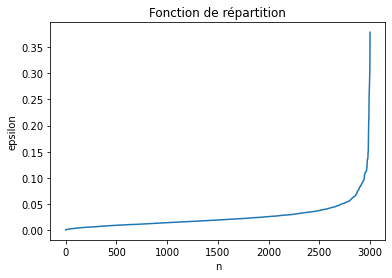

Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


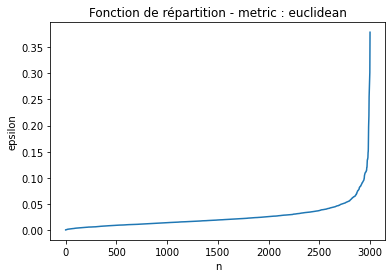

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.08696613 0.09179758 0.09662903 0.10146048 0.10629193]
silhouette : -0.2274960593282048, calinski : 200.50631997267413, DB : 0.471558440627012, time : 0.010532617568969727, clusters : 136
silhouette : 0.02431819425275566, calinski : 1241.0410346487915, DB : 1.1422212863472785, time : 0.012328863143920898, clusters : 11
silhouette : 0.17025379089427703, calinski : 1131.4663942027955, DB : 1.3029666107105375, time : 0.009791135787963867, clusters : 8
silhouette : 0.06908847698524917, calinski : 747.8492972702205, DB : 1.1522669339426146, time : 0.01047372817993164, clusters : 8
silhouette : -0.11425321079141948, calinski : 536.338572024745, DB : 1.413698869342019, time : 0.008023262023925781, clusters : 7
silhouette : -0.20530599101968514, calinski : 223.4526953525645, DB :

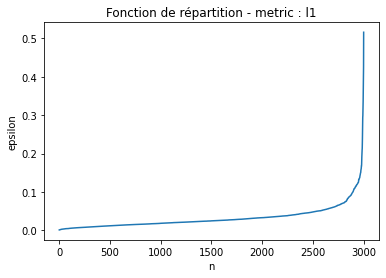

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : -0.2418979201255591, calinski : 206.84672270498547, DB : 0.47580078745881504, time : 0.017924070358276367, clusters : 132
silhouette : 0.12270100225144216, calinski : 1482.9814687140981, DB : 1.0227727296638263, time : 0.014232635498046875, clusters : 9
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.009685754776000977, clusters : 6
silhouette : 0.12422787941740364, calinski : 891.118429100822, DB : 1.165750560797128, time : 0.019835948944091797, clusters : 7
silhouette : -0.11362778846872094, calinski : 486.19676059253237, DB : 1.3632844311873749, time : 0.011669397354125977, clusters : 8
silhouette : -0.1876210934346193, calinski : 228.62099640105757, DB : 0.467

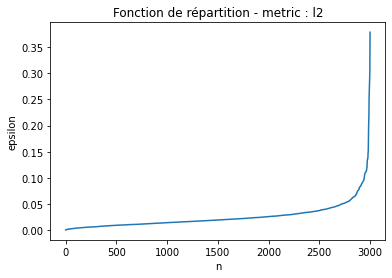

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.08696613 0.09179758 0.09662903 0.10146048 0.10629193]
silhouette : -0.2274960593282048, calinski : 200.50631997267413, DB : 0.471558440627012, time : 0.00922703742980957, clusters : 136
silhouette : 0.02431819425275566, calinski : 1241.0410346487915, DB : 1.1422212863472785, time : 0.016483545303344727, clusters : 11
silhouette : 0.17025379089427703, calinski : 1131.4663942027955, DB : 1.3029666107105375, time : 0.009204864501953125, clusters : 8
silhouette : 0.06908847698524917, calinski : 747.8492972702205, DB : 1.1522669339426146, time : 0.012486457824707031, clusters : 8
silhouette : -0.11425321079141948, calinski : 536.338572024745, DB : 1.413698869342019, time : 0.007841825485229492, clusters : 7
silhouette : -0.20530599101968514, calinski : 223.4526953525645, DB : 0.4658

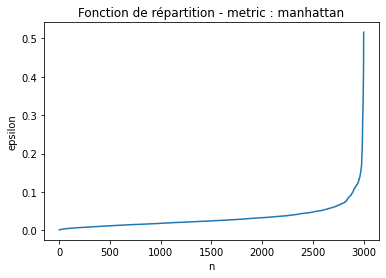

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : -0.2418979201255591, calinski : 206.84672270498547, DB : 0.47580078745881504, time : 0.010185956954956055, clusters : 132
silhouette : 0.12270100225144216, calinski : 1482.9814687140981, DB : 1.0227727296638263, time : 0.014213800430297852, clusters : 9
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.010789632797241211, clusters : 6
silhouette : 0.12422787941740364, calinski : 891.118429100822, DB : 1.165750560797128, time : 0.008843660354614258, clusters : 7
silhouette : -0.11362778846872094, calinski : 486.19676059253237, DB : 1.3632844311873749, time : 0.009812355041503906, clusters : 8
silhouette : -0.1876210934346193, calinski : 228.62099640105757, DB 

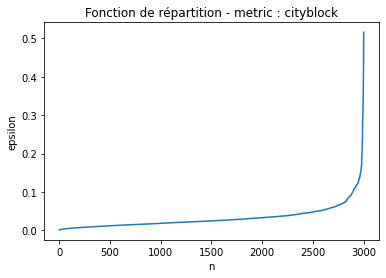

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : -0.2418979201255591, calinski : 206.84672270498547, DB : 0.47580078745881504, time : 0.012748479843139648, clusters : 132
silhouette : 0.12270100225144216, calinski : 1482.9814687140981, DB : 1.0227727296638263, time : 0.018944263458251953, clusters : 9
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.014704465866088867, clusters : 6
silhouette : 0.12422787941740364, calinski : 891.118429100822, DB : 1.165750560797128, time : 0.013789653778076172, clusters : 7
silhouette : -0.11362778846872094, calinski : 486.19676059253237, DB : 1.3632844311873749, time : 0.014375448226928711, clusters : 8
silhouette : -0.1876210934346193, calinski : 228.62099640105757, DB 

In [84]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"xclara.arff", params_eps={"n":5, "window":0.1, "center":0.98},
                                              params_min_pts={"n":5, "min":1,"max":15})

In [85]:
best_params

{'CAL': (array([2, 2, 2]), array([2, 2, 2]), array([1, 3, 4])),
 'SILH': (array([4, 4, 4]), array([4, 4, 4]), array([1, 3, 4])),
 'DB': (array([4, 4]), array([0, 0]), array([0, 2]))}

In [86]:
EPS

{'euclidean': array([0.08696613, 0.09179758, 0.09662903, 0.10146048, 0.10629193]),
 'l1': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274]),
 'l2': array([0.08696613, 0.09179758, 0.09662903, 0.10146048, 0.10629193]),
 'manhattan': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274]),
 'cityblock': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274])}

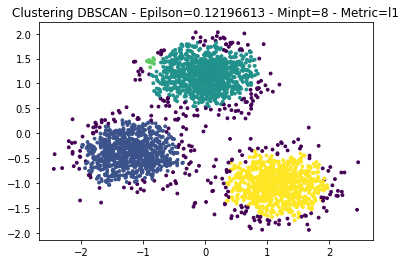

Estimated number of clusters: 4
Estimated number of noise points: 310
coefficient de silhouette: 0.453448
coefficient de calinsky: 2796.852441
coefficient de Davies Bouldin: 1.274178
Running time: 0.011945


In [87]:
doDBSCAN(path+"xclara.arff",0.12196613,8,'l1')

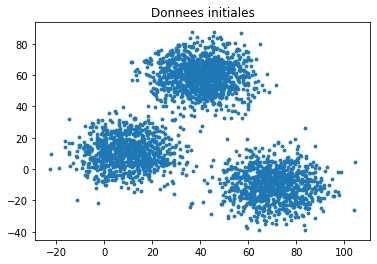

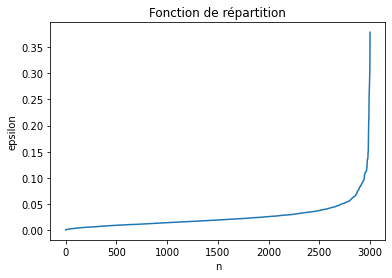

Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
Paramètres 'min_pts' testés : [ 6.  7.  8.  9. 10.]


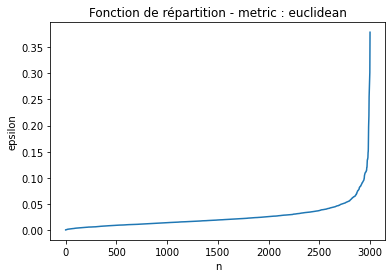

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.08696613 0.09179758 0.09662903 0.10146048 0.10629193]
silhouette : 0.12489176210669206, calinski : 1420.7751798432062, DB : 1.2957197383839758, time : 0.009111404418945312, clusters : 8
silhouette : 0.06533064295707677, calinski : 1157.1971759216844, DB : 1.3033483402447472, time : 0.007719993591308594, clusters : 9
silhouette : 0.17025379089427703, calinski : 1131.4663942027955, DB : 1.3029666107105375, time : 0.01199030876159668, clusters : 8
silhouette : 0.49044286470236664, calinski : 2625.5973416389215, DB : 1.392442889780131, time : 0.008451461791992188, clusters : 3
silhouette : 0.18645144658364657, calinski : 1232.294335604133, DB : 1.2134481762358817, time : 0.010274410247802734, clusters : 6
silhouette : 0.3855163995401201, calinski : 2377.2324070645145, DB : 1

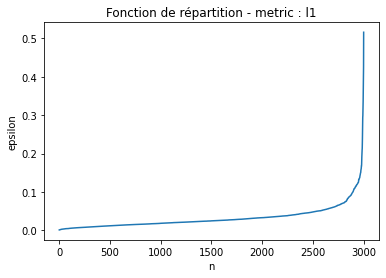

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : 0.14610626655340395, calinski : 1643.569538558631, DB : 1.1592982408336736, time : 0.009721994400024414, clusters : 7
silhouette : 0.17662619798616463, calinski : 1465.6382983557376, DB : 1.4466767760799941, time : 0.009132623672485352, clusters : 7
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.009574651718139648, clusters : 6
silhouette : 0.15764456080782074, calinski : 1467.9279384884408, DB : 1.152264789604575, time : 0.009234189987182617, clusters : 6
silhouette : 0.36853735456867687, calinski : 1922.3313630865484, DB : 1.2727910917769294, time : 0.011307477951049805, clusters : 4
silhouette : 0.37787620481959006, calinski : 2104.1765263362977, DB : 1.126367

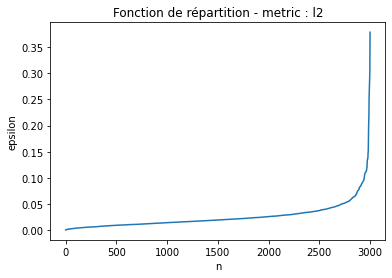

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0008206797532100271 
Distance maximale entre un échantillon et son premier voisin : 0.3779551846995892 
[0.08696613 0.09179758 0.09662903 0.10146048 0.10629193]
silhouette : 0.12489176210669206, calinski : 1420.7751798432062, DB : 1.2957197383839758, time : 0.010409355163574219, clusters : 8
silhouette : 0.06533064295707677, calinski : 1157.1971759216844, DB : 1.3033483402447472, time : 0.008332014083862305, clusters : 9
silhouette : 0.17025379089427703, calinski : 1131.4663942027955, DB : 1.3029666107105375, time : 0.009674549102783203, clusters : 8
silhouette : 0.49044286470236664, calinski : 2625.5973416389215, DB : 1.392442889780131, time : 0.007693290710449219, clusters : 3
silhouette : 0.18645144658364657, calinski : 1232.294335604133, DB : 1.2134481762358817, time : 0.008131980895996094, clusters : 6
silhouette : 0.3855163995401201, calinski : 2377.2324070645145, DB : 1.20404

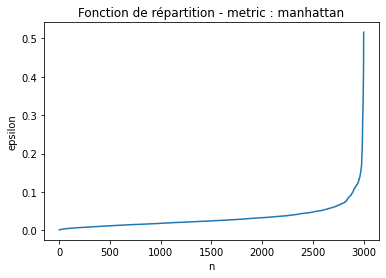

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : 0.14610626655340395, calinski : 1643.569538558631, DB : 1.1592982408336736, time : 0.010244369506835938, clusters : 7
silhouette : 0.17662619798616463, calinski : 1465.6382983557376, DB : 1.4466767760799941, time : 0.009829998016357422, clusters : 7
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.011458396911621094, clusters : 6
silhouette : 0.15764456080782074, calinski : 1467.9279384884408, DB : 1.152264789604575, time : 0.008885383605957031, clusters : 6
silhouette : 0.36853735456867687, calinski : 1922.3313630865484, DB : 1.2727910917769294, time : 0.009426355361938477, clusters : 4
silhouette : 0.37787620481959006, calinski : 2104.1765263362977, DB : 1

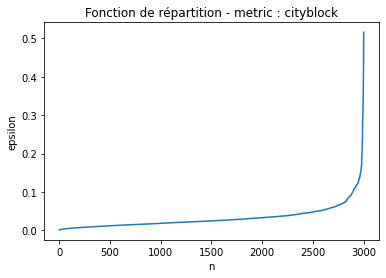

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0011517578674702378 
Distance maximale entre un échantillon et son premier voisin : 0.51584202742155 
[0.10976952 0.11586782 0.12196613 0.12806443 0.13416274]
silhouette : 0.14610626655340395, calinski : 1643.569538558631, DB : 1.1592982408336736, time : 0.01277923583984375, clusters : 7
silhouette : 0.17662619798616463, calinski : 1465.6382983557376, DB : 1.4466767760799941, time : 0.012744665145874023, clusters : 7
silhouette : 0.19376315792250579, calinski : 1592.7621194312942, DB : 1.4587955820246281, time : 0.014043331146240234, clusters : 6
silhouette : 0.15764456080782074, calinski : 1467.9279384884408, DB : 1.152264789604575, time : 0.013190984725952148, clusters : 6
silhouette : 0.36853735456867687, calinski : 1922.3313630865484, DB : 1.2727910917769294, time : 0.013424873352050781, clusters : 4
silhouette : 0.37787620481959006, calinski : 2104.1765263362977, DB : 1.

In [91]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"xclara.arff", params_eps={"n":5, "window":0.1, "center":0.98},
                                              params_min_pts={"n":5, "min":6,"max":10})

In [92]:
best_params

{'CAL': (array([4, 4, 4]), array([0, 0, 0]), array([1, 3, 4])),
 'SILH': (array([0, 0]), array([3, 3]), array([0, 2])),
 'DB': (array([4, 4]), array([2, 2]), array([0, 2]))}

In [93]:
EPS

{'euclidean': array([0.08696613, 0.09179758, 0.09662903, 0.10146048, 0.10629193]),
 'l1': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274]),
 'l2': array([0.08696613, 0.09179758, 0.09662903, 0.10146048, 0.10629193]),
 'manhattan': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274]),
 'cityblock': array([0.10976952, 0.11586782, 0.12196613, 0.12806443, 0.13416274])}

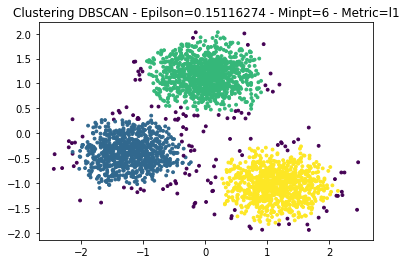

Estimated number of clusters: 3
Estimated number of noise points: 137
coefficient de silhouette: 0.627751
coefficient de calinsky: 5276.784889
coefficient de Davies Bouldin: 1.394926
Running time: 0.012698


In [103]:
doDBSCAN(path+"xclara.arff",0.15116274,6,'l1')

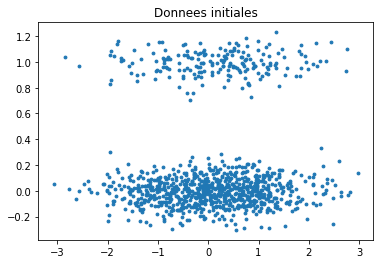

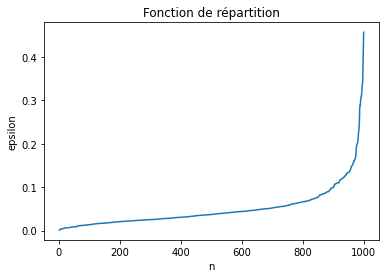

Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


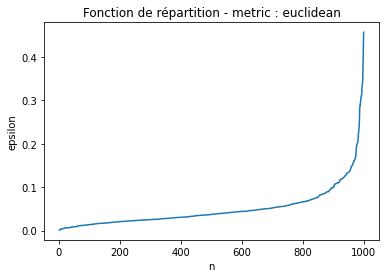

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.18154447 0.19163027 0.20171608 0.21180188 0.22188768]
silhouette : -0.2383887812242546, calinski : 41.44668183744187, DB : 0.5094163990367657, time : 0.0037610530853271484, clusters : 36
silhouette : 0.18534478660321185, calinski : 123.50073906655108, DB : 1.4265649803637637, time : 0.012178182601928711, clusters : 9
silhouette : 0.4137038363656829, calinski : 217.3383720870919, DB : 1.9863128060800082, time : 0.009125232696533203, clusters : 3
silhouette : 0.37033555445289884, calinski : 134.58570312247332, DB : 1.8700444784457262, time : 0.0055925846099853516, clusters : 4
silhouette : 0.310663019889089, calinski : 108.75968288117183, DB : 1.8022895797857637, time : 0.004820346832275391, clusters : 4
silhouette : -0.2273769521456452, calinski : 43.766438838433245, DB 

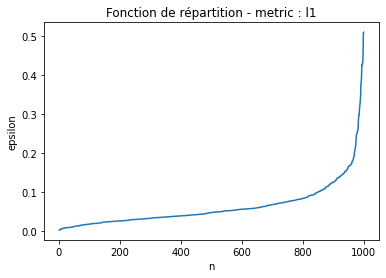

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.22983967 0.24260854 0.25537741 0.26814628 0.28091515]
silhouette : -0.2624901296346479, calinski : 37.726805253415904, DB : 0.4779409165759717, time : 0.014680862426757812, clusters : 36
silhouette : 0.18161780796527802, calinski : 157.621466293614, DB : 1.6854317329663027, time : 0.005439043045043945, clusters : 6
silhouette : 0.3366407285149033, calinski : 239.85323193285598, DB : 2.0558733822825475, time : 0.005711555480957031, clusters : 3
silhouette : 0.38017344307508216, calinski : 140.03251164364434, DB : 1.8730463060994658, time : 0.005778312683105469, clusters : 4
silhouette : 0.327820012486596, calinski : 146.43614847733483, DB : 1.9045725922675736, time : 0.007546901702880859, clusters : 3
silhouette : -0.284317978875406, calinski : 38.770017175929624, DB : 0.5284492

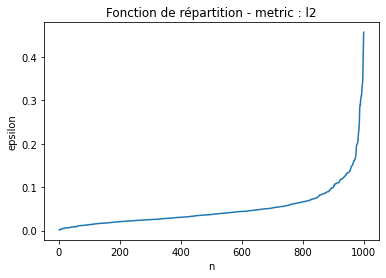

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.18154447 0.19163027 0.20171608 0.21180188 0.22188768]
silhouette : -0.2383887812242546, calinski : 41.44668183744187, DB : 0.5094163990367657, time : 0.0050089359283447266, clusters : 36
silhouette : 0.18534478660321185, calinski : 123.50073906655108, DB : 1.4265649803637637, time : 0.004977226257324219, clusters : 9
silhouette : 0.4137038363656829, calinski : 217.3383720870919, DB : 1.9863128060800082, time : 0.0076465606689453125, clusters : 3
silhouette : 0.37033555445289884, calinski : 134.58570312247332, DB : 1.8700444784457262, time : 0.009351253509521484, clusters : 4
silhouette : 0.310663019889089, calinski : 108.75968288117183, DB : 1.8022895797857637, time : 0.005000591278076172, clusters : 4
silhouette : -0.2273769521456452, calinski : 43.766438838433245, DB : 0.506

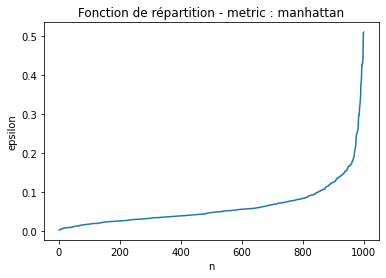

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.22983967 0.24260854 0.25537741 0.26814628 0.28091515]
silhouette : -0.2624901296346479, calinski : 37.726805253415904, DB : 0.4779409165759717, time : 0.00476527214050293, clusters : 36
silhouette : 0.18161780796527802, calinski : 157.621466293614, DB : 1.6854317329663027, time : 0.005359172821044922, clusters : 6
silhouette : 0.3366407285149033, calinski : 239.85323193285598, DB : 2.0558733822825475, time : 0.0054645538330078125, clusters : 3
silhouette : 0.38017344307508216, calinski : 140.03251164364434, DB : 1.8730463060994658, time : 0.005689382553100586, clusters : 4
silhouette : 0.327820012486596, calinski : 146.43614847733483, DB : 1.9045725922675736, time : 0.0053081512451171875, clusters : 3
silhouette : -0.284317978875406, calinski : 38.770017175929624, DB : 0

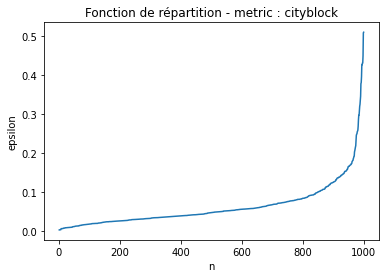

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.22983967 0.24260854 0.25537741 0.26814628 0.28091515]
silhouette : -0.2624901296346479, calinski : 37.726805253415904, DB : 0.4779409165759717, time : 0.0066068172454833984, clusters : 36
silhouette : 0.18161780796527802, calinski : 157.621466293614, DB : 1.6854317329663027, time : 0.005688905715942383, clusters : 6
silhouette : 0.3366407285149033, calinski : 239.85323193285598, DB : 2.0558733822825475, time : 0.005297422409057617, clusters : 3
silhouette : 0.38017344307508216, calinski : 140.03251164364434, DB : 1.8730463060994658, time : 0.005243778228759766, clusters : 4
silhouette : 0.327820012486596, calinski : 146.43614847733483, DB : 1.9045725922675736, time : 0.007407665252685547, clusters : 3
silhouette : -0.284317978875406, calinski : 38.770017175929624, DB : 0

In [125]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"long3.arff", 
                                               params_eps={"n":5, "window":0.1, "center":0.98}, 
                                               params_min_pts={'n':5, 'min':1, 'max':15})

In [126]:
best_params

{'CAL': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([4, 4, 4]), array([1, 1, 1]), array([1, 3, 4])),
 'DB': (array([0, 0, 0]), array([0, 0, 0]), array([1, 3, 4]))}

In [127]:
EPS

{'euclidean': array([0.18154447, 0.19163027, 0.20171608, 0.21180188, 0.22188768]),
 'l1': array([0.22983967, 0.24260854, 0.25537741, 0.26814628, 0.28091515]),
 'l2': array([0.18154447, 0.19163027, 0.20171608, 0.21180188, 0.22188768]),
 'manhattan': array([0.22983967, 0.24260854, 0.25537741, 0.26814628, 0.28091515]),
 'cityblock': array([0.22983967, 0.24260854, 0.25537741, 0.26814628, 0.28091515])}

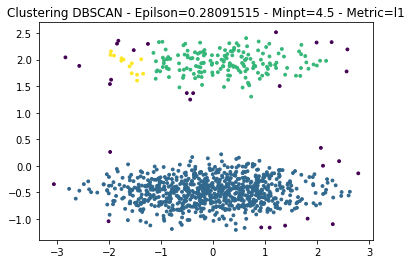

Estimated number of clusters: 3
Estimated number of noise points: 29
coefficient de silhouette: 0.485312
coefficient de calinsky: 296.494848
coefficient de Davies Bouldin: 2.275277
Running time: 0.004230


In [128]:
doDBSCAN(path+"long3.arff",0.28091515,4.5,'l1')

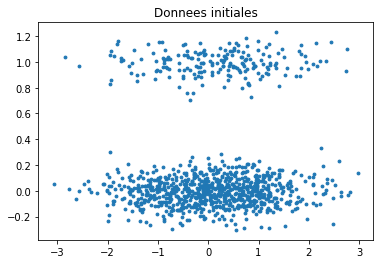

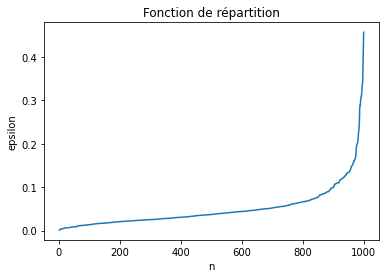

Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


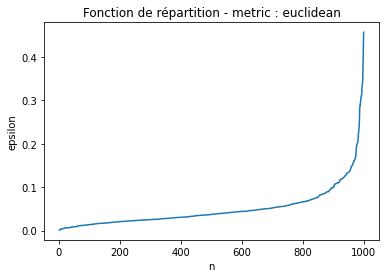

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.26971659 0.28470084 0.2996851  0.31466935 0.3296536 ]
silhouette : 0.02846125453792607, calinski : 65.212641797856, DB : 0.39894580764994075, time : 0.004382133483886719, clusters : 17
silhouette : 0.5453813314085362, calinski : 423.61130503248813, DB : 2.516927729767293, time : 0.006270647048950195, clusters : 2
silhouette : 0.4958270287072746, calinski : 293.24740822025444, DB : 2.405209377729216, time : 0.0057353973388671875, clusters : 3
silhouette : 0.38540276380989447, calinski : 284.641099952363, DB : 2.3624537445492515, time : 0.0057141780853271484, clusters : 3
silhouette : 0.5148976639446071, calinski : 354.42427289478474, DB : 2.41121709797663, time : 0.005551815032958984, clusters : 2
silhouette : 0.02860374476268281, calinski : 69.12135521340457, DB : 0.396

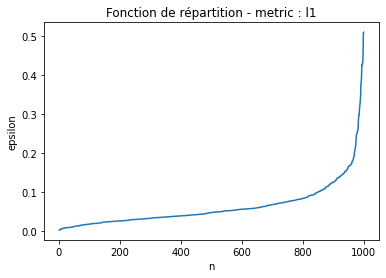

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.31036555 0.32760808 0.34485061 0.36209314 0.37933567]
silhouette : -0.0790048442716386, calinski : 58.713516679295985, DB : 0.44460695202936723, time : 0.011754989624023438, clusters : 19
silhouette : 0.5370600697269294, calinski : 414.9399455079308, DB : 2.5509067909902465, time : 0.0072023868560791016, clusters : 2
silhouette : 0.4399018015072867, calinski : 217.08155909623358, DB : 2.0866895961294825, time : 0.010415077209472656, clusters : 4
silhouette : 0.5112562181798824, calinski : 352.1893808647904, DB : 2.4035656639785903, time : 0.019656896591186523, clusters : 2
silhouette : 0.4378148541747014, calinski : 238.64476170127546, DB : 2.0536043658369985, time : 0.006859779357910156, clusters : 3
silhouette : -0.06779521352607924, calinski : 65.3363672931975, DB : 0.439133

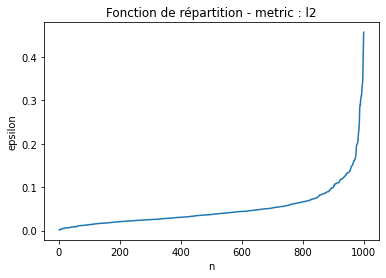

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0016114348923732921 
Distance maximale entre un échantillon et son premier voisin : 0.45675539209480714 
[0.26971659 0.28470084 0.2996851  0.31466935 0.3296536 ]
silhouette : 0.02846125453792607, calinski : 65.212641797856, DB : 0.39894580764994075, time : 0.005646467208862305, clusters : 17
silhouette : 0.5453813314085362, calinski : 423.61130503248813, DB : 2.516927729767293, time : 0.005486249923706055, clusters : 2
silhouette : 0.4958270287072746, calinski : 293.24740822025444, DB : 2.405209377729216, time : 0.009239912033081055, clusters : 3
silhouette : 0.38540276380989447, calinski : 284.641099952363, DB : 2.3624537445492515, time : 0.0054662227630615234, clusters : 3
silhouette : 0.5148976639446071, calinski : 354.42427289478474, DB : 2.41121709797663, time : 0.005486488342285156, clusters : 2
silhouette : 0.02860374476268281, calinski : 69.12135521340457, DB : 0.39665723238

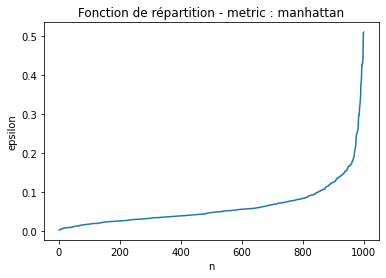

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.31036555 0.32760808 0.34485061 0.36209314 0.37933567]
silhouette : -0.0790048442716386, calinski : 58.713516679295985, DB : 0.44460695202936723, time : 0.0049746036529541016, clusters : 19
silhouette : 0.5370600697269294, calinski : 414.9399455079308, DB : 2.5509067909902465, time : 0.006280183792114258, clusters : 2
silhouette : 0.4399018015072867, calinski : 217.08155909623358, DB : 2.0866895961294825, time : 0.005986452102661133, clusters : 4
silhouette : 0.5112562181798824, calinski : 352.1893808647904, DB : 2.4035656639785903, time : 0.005963563919067383, clusters : 2
silhouette : 0.4378148541747014, calinski : 238.64476170127546, DB : 2.0536043658369985, time : 0.005942106246948242, clusters : 3
silhouette : -0.06779521352607924, calinski : 65.3363672931975, DB : 0

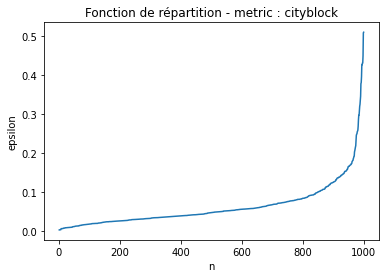

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0021886564213903503 
Distance maximale entre un échantillon et son premier voisin : 0.5088796182700002 
[0.31036555 0.32760808 0.34485061 0.36209314 0.37933567]
silhouette : -0.0790048442716386, calinski : 58.713516679295985, DB : 0.44460695202936723, time : 0.006172657012939453, clusters : 19
silhouette : 0.5370600697269294, calinski : 414.9399455079308, DB : 2.5509067909902465, time : 0.006064653396606445, clusters : 2
silhouette : 0.4399018015072867, calinski : 217.08155909623358, DB : 2.0866895961294825, time : 0.006024360656738281, clusters : 4
silhouette : 0.5112562181798824, calinski : 352.1893808647904, DB : 2.4035656639785903, time : 0.005963802337646484, clusters : 2
silhouette : 0.4378148541747014, calinski : 238.64476170127546, DB : 2.0536043658369985, time : 0.006187915802001953, clusters : 3
silhouette : -0.06779521352607924, calinski : 65.3363672931975, DB : 0.

In [129]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"long3.arff", 
                                               params_eps={"n":5, "window":0.1, "center":0.99}, 
                                               params_min_pts={'n':5, 'min':1, 'max':15})

In [130]:
best_params

{'CAL': (array([3, 3]), array([1, 1]), array([0, 2])),
 'SILH': (array([3, 3, 3, 4, 4, 4]),
  array([1, 1, 1, 1, 1, 1]),
  array([1, 3, 4, 1, 3, 4])),
 'DB': (array([2, 2, 2, 3, 3, 3]),
  array([0, 0, 0, 0, 0, 0]),
  array([1, 3, 4, 1, 3, 4]))}

In [131]:
EPS

{'euclidean': array([0.26971659, 0.28470084, 0.2996851 , 0.31466935, 0.3296536 ]),
 'l1': array([0.31036555, 0.32760808, 0.34485061, 0.36209314, 0.37933567]),
 'l2': array([0.26971659, 0.28470084, 0.2996851 , 0.31466935, 0.3296536 ]),
 'manhattan': array([0.31036555, 0.32760808, 0.34485061, 0.36209314, 0.37933567]),
 'cityblock': array([0.31036555, 0.32760808, 0.34485061, 0.36209314, 0.37933567])}

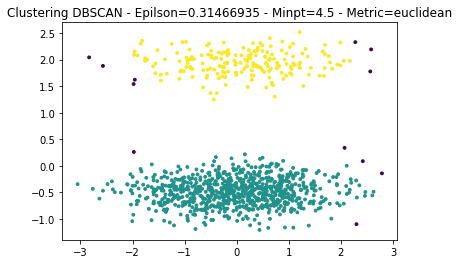

Estimated number of clusters: 2
Estimated number of noise points: 12
coefficient de silhouette: 0.557323
coefficient de calinsky: 434.893503
coefficient de Davies Bouldin: 3.039741
Running time: 0.004364


In [132]:
doDBSCAN(path+"long3.arff",0.31466935,4.5,'euclidean')

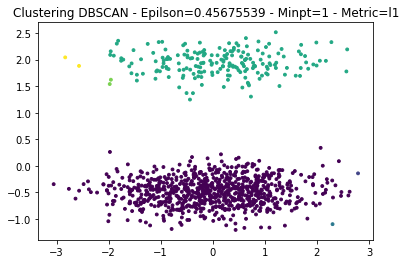

Estimated number of clusters: 6
Estimated number of noise points: 0
coefficient de silhouette: 0.351288
coefficient de calinsky: 190.264962
coefficient de Davies Bouldin: 0.466300
Running time: 0.005511


In [140]:
doDBSCAN(path+"long3.arff",0.45675539,1,'l1')

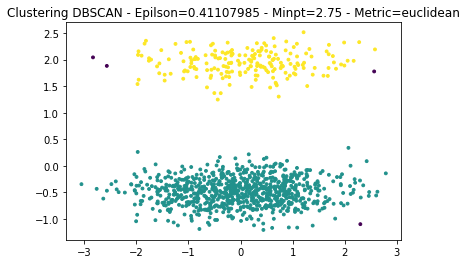

Estimated number of clusters: 2
Estimated number of noise points: 4
coefficient de silhouette: 0.563363
coefficient de calinsky: 436.689814
coefficient de Davies Bouldin: 3.761404
Running time: 0.013047


In [141]:
doDBSCAN(path+"long3.arff",0.41107985,2.75,'euclidean')

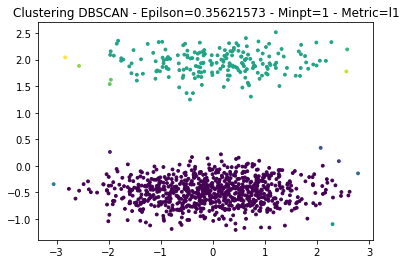

Estimated number of clusters: 13
Estimated number of noise points: 0
coefficient de silhouette: 0.169397
coefficient de calinsky: 84.778599
coefficient de Davies Bouldin: 0.389128
Running time: 0.004439


In [142]:
doDBSCAN(path+"long3.arff",0.35621573,1,'l1')

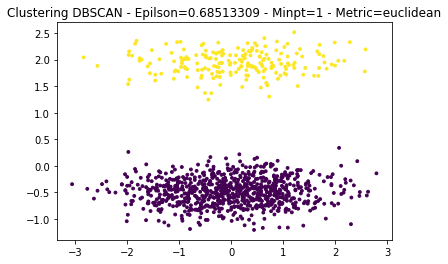

Estimated number of clusters: 2
Estimated number of noise points: 0
coefficient de silhouette: 0.566700
coefficient de calinsky: 884.141676
coefficient de Davies Bouldin: 0.711187
Running time: 0.006650


In [145]:
doDBSCAN(path+"long3.arff",0.68513309,1,'euclidean')

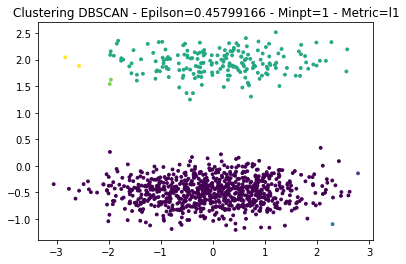

Estimated number of clusters: 6
Estimated number of noise points: 0
coefficient de silhouette: 0.351288
coefficient de calinsky: 190.264962
coefficient de Davies Bouldin: 0.466300
Running time: 0.005408


In [146]:
doDBSCAN(path+"long3.arff",0.45799166,1,'l1')

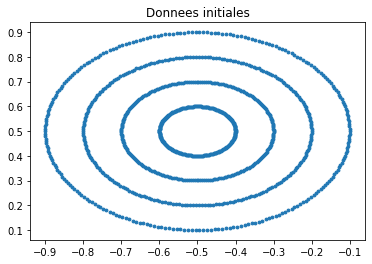

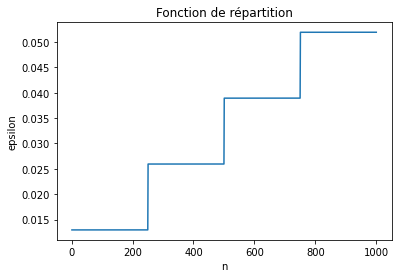

Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


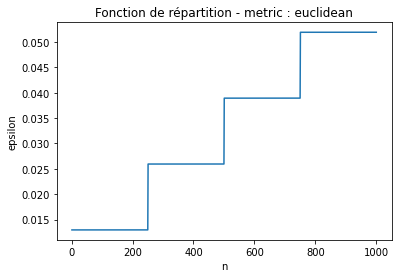

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04672143 0.04931706 0.05191269 0.05450833 0.05710396]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.0027310848236083984, clusters : 253
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.003457784652709961, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004708766937255859, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004229307174682617, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0029380321502685547, clusters : 0
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.003183126449584961, clusters : 253
silhouette : -0.0313374692744095, calinski : 9.67601670

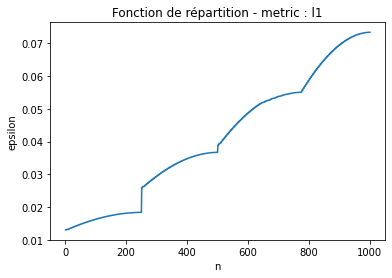

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -0.15257667372096662, calinski : 6.088709179800467, DB : 179452952483366.47, time : 0.002847909927368164, clusters : 155
silhouette : -0.3132230861122132, calinski : 11.45354933794602, DB : 5568206320708840.0, time : 0.00347900390625, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.005906820297241211, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0040836334228515625, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004835844039916992, clusters : 0
silhouette : -0.1530641547894185, calinski : 7.93899464048201, DB : 233741240629594.75, time : 0.0034170150756835938, clusters : 119
silhouette : -0.26160

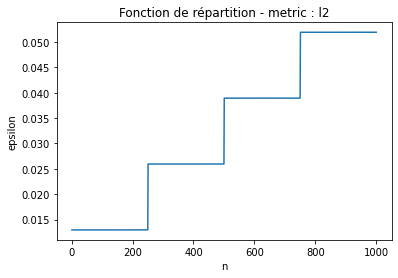

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04672143 0.04931706 0.05191269 0.05450833 0.05710396]
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.002780914306640625, clusters : 253
silhouette : -0.0313374692744095, calinski : 9.676016700359315e-31, DB : 0.0, time : 0.003617525100708008, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0031557083129882812, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0029675960540771484, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002901792526245117, clusters : 0
silhouette : -0.13948899039493431, calinski : 3.3877570119690157, DB : 109941532153841.4, time : 0.003094196319580078, clusters : 253
silhouette : -0.0313374692744095, calinski : 9.676016700359315

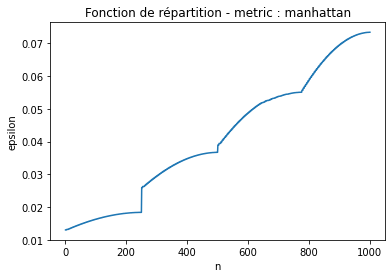

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -0.15257667372096662, calinski : 6.088709179800467, DB : 179452952483366.47, time : 0.0034427642822265625, clusters : 155
silhouette : -0.3132230861122132, calinski : 11.45354933794602, DB : 5568206320708840.0, time : 0.003467082977294922, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.0034134387969970703, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0033364295959472656, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003148794174194336, clusters : 0
silhouette : -0.1530641547894185, calinski : 7.93899464048201, DB : 233741240629594.75, time : 0.003335714340209961, clusters : 119
silhouett

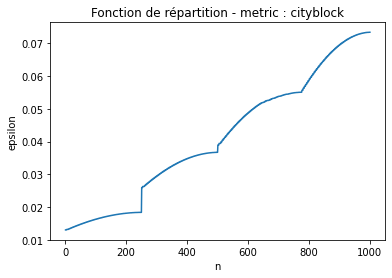

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -0.15257667372096662, calinski : 6.088709179800467, DB : 179452952483366.47, time : 0.0035619735717773438, clusters : 155
silhouette : -0.3132230861122132, calinski : 11.45354933794602, DB : 5568206320708840.0, time : 0.0042879581451416016, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.0033621788024902344, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0033104419708251953, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0034945011138916016, clusters : 0
silhouette : -0.1530641547894185, calinski : 7.93899464048201, DB : 233741240629594.75, time : 0.0033905506134033203, clusters : 119
silhou

In [147]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"dartboard1.arff", params_eps={"n":5, "window":0.1, "center":0.95}, 
                                               params_min_pts={'n':5, 'min':1, 'max':15})

In [148]:
best_params

{'CAL': (array([2, 2, 2]), array([1, 1, 1]), array([1, 3, 4])),
 'SILH': (array([0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
  array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
  array([0, 2, 0, 2, 0, 2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])),
 'DB': (array([0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
  array([1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]),
  array([0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
         4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]))}

In [149]:
EPS

{'euclidean': array([0.04672143, 0.04931706, 0.05191269, 0.05450833, 0.05710396]),
 'l1': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342]),
 'l2': array([0.04672143, 0.04931706, 0.05191269, 0.05450833, 0.05710396]),
 'manhattan': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342]),
 'cityblock': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342])}

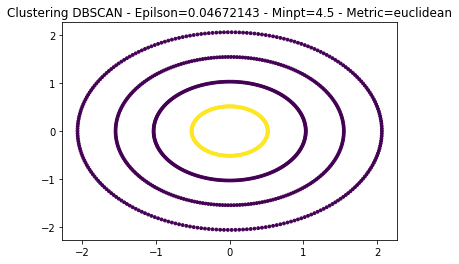

Estimated number of clusters: 1
Estimated number of noise points: 750
coefficient de silhouette: -0.031337
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000
Running time: 0.002439


In [153]:
doDBSCAN(path+"dartboard1.arff",0.04672143,4.5,'euclidean')

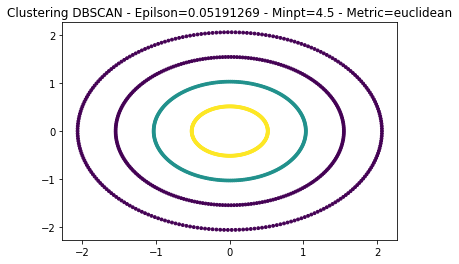

Estimated number of clusters: 2
Estimated number of noise points: 500
coefficient de silhouette: -0.049714
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000
Running time: 0.003575


In [154]:
doDBSCAN(path+"dartboard1.arff",0.05191269,4.5,'euclidean')

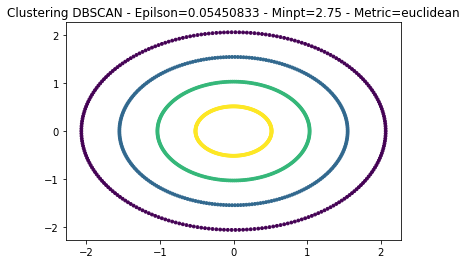

Estimated number of clusters: 4
Estimated number of noise points: 0
coefficient de silhouette: -0.042578
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000
Running time: 0.002677


In [160]:
doDBSCAN(path+"dartboard1.arff",0.05450833,2.75,'euclidean')

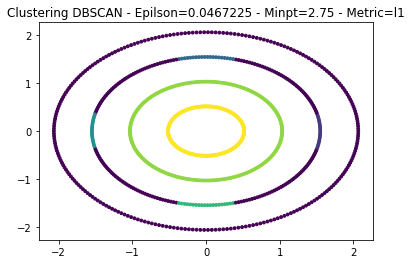

Estimated number of clusters: 6
Estimated number of noise points: 422
coefficient de silhouette: -0.214196
coefficient de calinsky: 16.717082
coefficient de Davies Bouldin: 6714646555439562.000000


In [233]:
doDBSCAN(path+"dartboard1.arff",0.0467225,2.75,'l1')

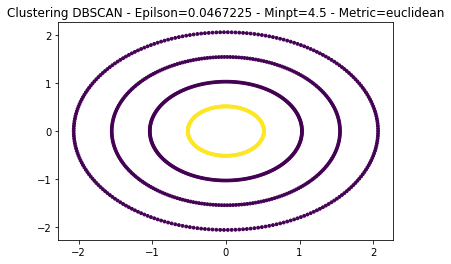

Estimated number of clusters: 1
Estimated number of noise points: 750
coefficient de silhouette: -0.031337
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000


In [234]:
doDBSCAN(path+"dartboard1.arff",0.0467225,4.5,'euclidean')

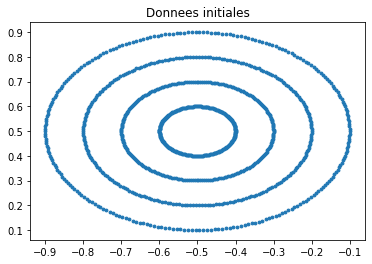

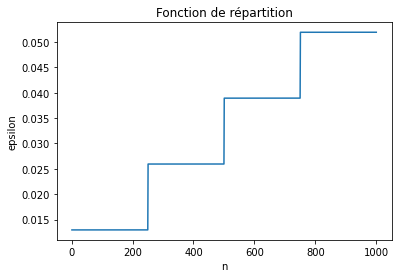

Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


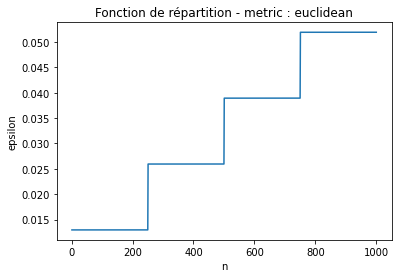

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04672143 0.04931706 0.05191269 0.05450833 0.05710396]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002626657485961914, clusters : 253
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0025157928466796875, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003329753875732422, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002645254135131836, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0036284923553466797, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0032989978790283203, clusters : 253
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0026912689208984375, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.

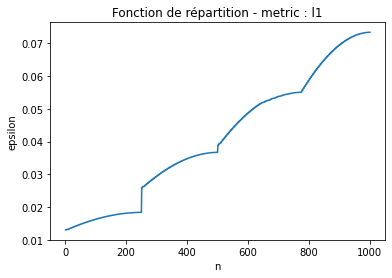

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0031549930572509766, clusters : 155
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002370595932006836, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.002417325973510742, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003730297088623047, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0036270618438720703, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0037012100219726562, clusters : 119
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003592967987060547, clusters : 5
silhouette : -0.27636654093313423

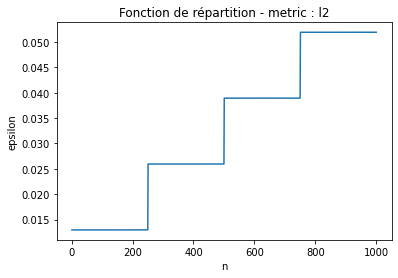

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.012974562315813301 
Distance maximale entre un échantillon et son premier voisin : 0.05191389432071155 
[0.04672143 0.04931706 0.05191269 0.05450833 0.05710396]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0028777122497558594, clusters : 253
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0032889842987060547, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0034019947052001953, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0029447078704833984, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0021827220916748047, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0021233558654785156, clusters : 253
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002576589584350586, clusters : 1
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.00195

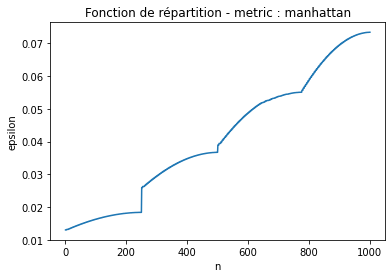

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.008329629898071289, clusters : 155
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0052411556243896484, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.004137992858886719, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0034637451171875, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0032339096069335938, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0035355091094970703, clusters : 119
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004409313201904297, clusters : 5
silhouette : -0.276366540933

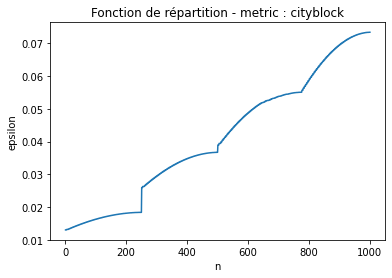

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.01298223889130088 
Distance maximale entre un échantillon et son premier voisin : 0.07340077850530924 
[0.06512189 0.06873977 0.07235766 0.07597554 0.07959342]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003113269805908203, clusters : 155
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.002808094024658203, clusters : 5
silhouette : -0.32481039489311886, calinski : 4.372937995198632, DB : 3.052784879439521, time : 0.00312042236328125, clusters : 4
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0037102699279785156, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.003436565399169922, clusters : 0
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.004308462142944336, clusters : 119
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0035326480865478516, clusters : 5
silhouette : -0.276366540933

In [168]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"dartboard1.arff", params_eps={"n":5, "window":0.1, "center":0.95}, 
                                               params_min_pts={'n':5, 'min':1, 'max':15}, cluster_filter=4)

In [169]:
best_params

{'CAL': (array([2, 2, 2]), array([2, 2, 2]), array([1, 3, 4])),
 'SILH': (array([3, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])),
 'DB': (array([3, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4]))}

In [170]:
EPS

{'euclidean': array([0.04672143, 0.04931706, 0.05191269, 0.05450833, 0.05710396]),
 'l1': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342]),
 'l2': array([0.04672143, 0.04931706, 0.05191269, 0.05450833, 0.05710396]),
 'manhattan': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342]),
 'cityblock': array([0.06512189, 0.06873977, 0.07235766, 0.07597554, 0.07959342])}

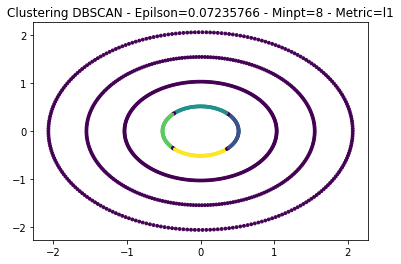

Estimated number of clusters: 4
Estimated number of noise points: 762
coefficient de silhouette: -0.222893
coefficient de calinsky: 6.704094
coefficient de Davies Bouldin: 3.674208
Running time: 0.003642


In [171]:
doDBSCAN(path+"dartboard1.arff",0.07235766,8,'l1')

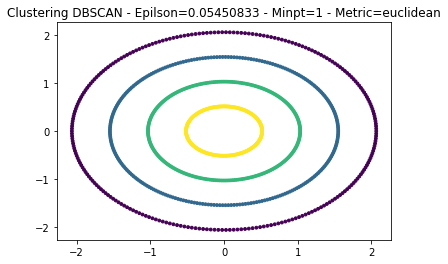

Estimated number of clusters: 4
Estimated number of noise points: 0
coefficient de silhouette: -0.042578
coefficient de calinsky: 0.000000
coefficient de Davies Bouldin: 0.000000
Running time: 0.003923


In [172]:
doDBSCAN(path+"dartboard1.arff",0.05450833,1,'euclidean')

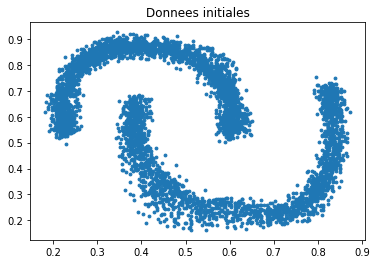

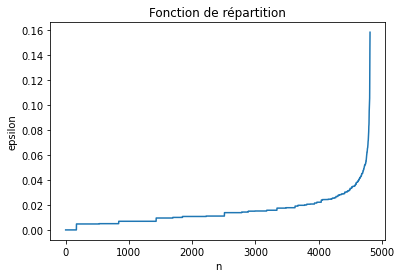

Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


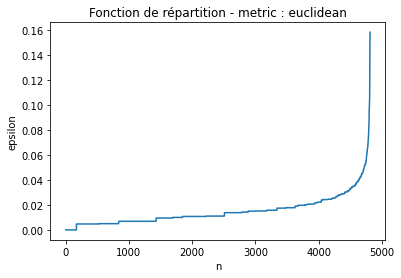

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.03180995 0.03357717 0.03534438 0.0371116  0.03887882]
silhouette : -0.46181744422709836, calinski : 49.923128167841185, DB : 0.8430553041903609, time : 0.013226985931396484, clusters : 540
silhouette : -0.37822983492384477, calinski : 160.20765842703986, DB : 1.369268636699066, time : 0.019339323043823242, clusters : 92
silhouette : -0.2789129581779972, calinski : 77.01313510131818, DB : 1.2469456617888448, time : 0.017586946487426758, clusters : 75
silhouette : -0.5060190911286135, calinski : 35.71331830701463, DB : 1.4045527915572604, time : 0.017107725143432617, clusters : 46
silhouette : -0.5640655473831722, calinski : 27.263375567443127, DB : 1.4332063018355474, time : 0.016941308975219727, clusters : 20
silhouette : -0.49367709445105473, calinski : 53.82557847896728, DB : 0.8701666

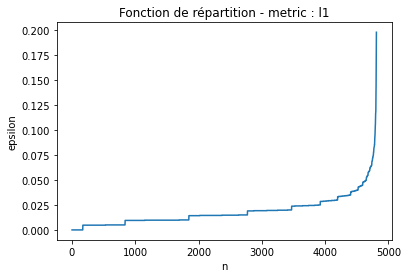

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.03987588 0.04209121 0.04430654 0.04652186 0.04873719]
silhouette : -0.4996533166686066, calinski : 33.596433863525284, DB : 0.8544406001333374, time : 0.015185117721557617, clusters : 504
silhouette : -0.3816716997725868, calinski : 143.61990737487017, DB : 1.3617904860492078, time : 0.020289182662963867, clusters : 80
silhouette : -0.26768609153384015, calinski : 95.22213282509144, DB : 1.2459944946479848, time : 0.019794702529907227, clusters : 70
silhouette : -0.47902498476194066, calinski : 44.502076865491254, DB : 1.3933479369781003, time : 0.01919245719909668, clusters : 42
silhouette : -0.5336905047435406, calinski : 30.03454989722062, DB : 1.400351927266038, time : 0.018990278244018555, clusters : 23
silhouette : -0.5027661831871264, calinski : 34.72795808894112, DB : 0.8591206375019286

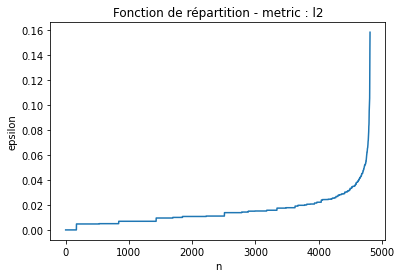

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.03180995 0.03357717 0.03534438 0.0371116  0.03887882]
silhouette : -0.46181744422709836, calinski : 49.923128167841185, DB : 0.8430553041903609, time : 0.01655125617980957, clusters : 540
silhouette : -0.37822983492384477, calinski : 160.20765842703986, DB : 1.369268636699066, time : 0.01780557632446289, clusters : 92
silhouette : -0.2789129581779972, calinski : 77.01313510131818, DB : 1.2469456617888448, time : 0.017433643341064453, clusters : 75
silhouette : -0.5060190911286135, calinski : 35.71331830701463, DB : 1.4045527915572604, time : 0.0186464786529541, clusters : 46
silhouette : -0.5640655473831722, calinski : 27.263375567443127, DB : 1.4332063018355474, time : 0.017037630081176758, clusters : 20
silhouette : -0.49367709445105473, calinski : 53.82557847896728, DB : 0.870166659307739, t

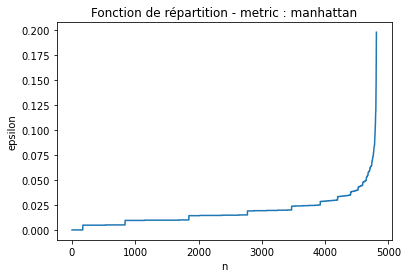

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.03987588 0.04209121 0.04430654 0.04652186 0.04873719]
silhouette : -0.4996533166686066, calinski : 33.596433863525284, DB : 0.8544406001333374, time : 0.014267683029174805, clusters : 504
silhouette : -0.3816716997725868, calinski : 143.61990737487017, DB : 1.3617904860492078, time : 0.019672870635986328, clusters : 80
silhouette : -0.26768609153384015, calinski : 95.22213282509144, DB : 1.2459944946479848, time : 0.019373655319213867, clusters : 70
silhouette : -0.47902498476194066, calinski : 44.502076865491254, DB : 1.3933479369781003, time : 0.0190274715423584, clusters : 42
silhouette : -0.5336905047435406, calinski : 30.03454989722062, DB : 1.400351927266038, time : 0.018921375274658203, clusters : 23
silhouette : -0.5027661831871264, calinski : 34.72795808894112, DB : 0.8591206375

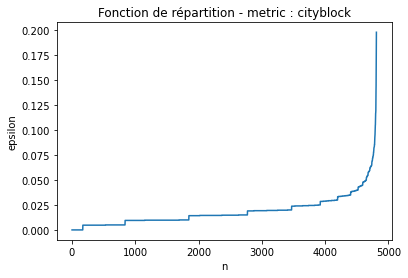

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.03987588 0.04209121 0.04430654 0.04652186 0.04873719]
silhouette : -0.4996533166686066, calinski : 33.596433863525284, DB : 0.8544406001333374, time : 0.020849943161010742, clusters : 504
silhouette : -0.3816716997725868, calinski : 143.61990737487017, DB : 1.3617904860492078, time : 0.019692420959472656, clusters : 80
silhouette : -0.26768609153384015, calinski : 95.22213282509144, DB : 1.2459944946479848, time : 0.01954960823059082, clusters : 70
silhouette : -0.47902498476194066, calinski : 44.502076865491254, DB : 1.3933479369781003, time : 0.01915454864501953, clusters : 42
silhouette : -0.5336905047435406, calinski : 30.03454989722062, DB : 1.400351927266038, time : 0.019823074340820312, clusters : 23
silhouette : -0.5027661831871264, calinski : 34.72795808894112, DB : 0.8591206375

In [182]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"banana.arff", 
                                               params_eps={"n":5, "window":0.1,"center":0.95},
                                                params_min_pts={'n':5, 'min':1, 'max':15})
                                                

In [183]:
best_params

{'CAL': (array([4, 4, 4]), array([2, 2, 2]), array([1, 3, 4])),
 'SILH': (array([4, 4]), array([3, 3]), array([0, 2])),
 'DB': (array([0, 0]), array([0, 0]), array([0, 2]))}

In [184]:
EPS

{'euclidean': array([0.03180995, 0.03357717, 0.03534438, 0.0371116 , 0.03887882]),
 'l1': array([0.03987588, 0.04209121, 0.04430654, 0.04652186, 0.04873719]),
 'l2': array([0.03180995, 0.03357717, 0.03534438, 0.0371116 , 0.03887882]),
 'manhattan': array([0.03987588, 0.04209121, 0.04430654, 0.04652186, 0.04873719]),
 'cityblock': array([0.03987588, 0.04209121, 0.04430654, 0.04652186, 0.04873719])}

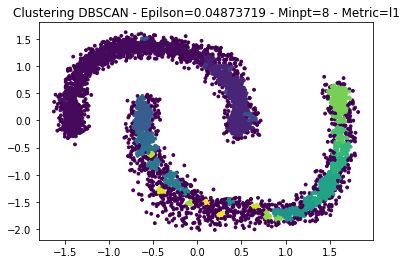

Estimated number of clusters: 38
Estimated number of noise points: 1240
coefficient de silhouette: -0.338604
coefficient de calinsky: 251.259321
coefficient de Davies Bouldin: 1.300665
Running time: 0.015744


In [185]:
doDBSCAN(path+"banana.arff",0.04873719,8,'l1')

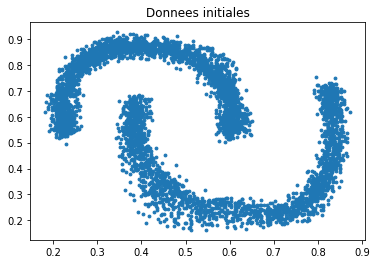

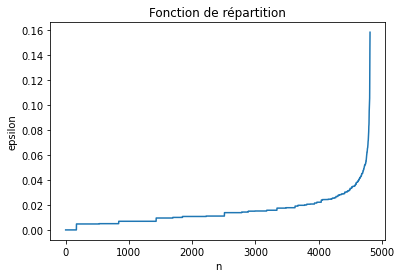

Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


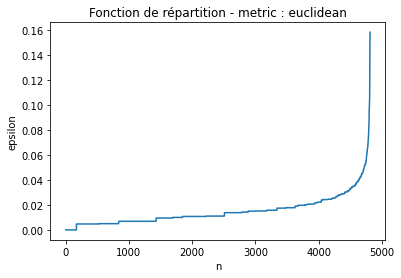

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.044261   0.04671994 0.04917889 0.05163783 0.05409678]
silhouette : -0.807257112512155, calinski : 21.232174934841833, DB : 1.1652167783567013, time : 0.018531084060668945, clusters : 198
silhouette : -0.3496590162388902, calinski : 288.77682308121274, DB : 2.3447348115031565, time : 0.02146148681640625, clusters : 30
silhouette : -0.01757393979269053, calinski : 314.92541160984695, DB : 1.4466159248979327, time : 0.021306514739990234, clusters : 23
silhouette : -0.10570590841548244, calinski : 283.10258911828157, DB : 1.3968514304099975, time : 0.019351959228515625, clusters : 30
silhouette : -0.1917552298271041, calinski : 155.64679871360377, DB : 1.2158831470528284, time : 0.018441438674926758, clusters : 33
silhouette : -0.8179985740710636, calinski : 25.32114799035825, DB : 1.1897764

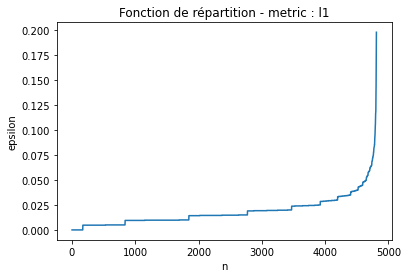

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.05637143 0.05950317 0.06263492 0.06576667 0.06889841]
silhouette : -0.8105933745073379, calinski : 22.565459473500496, DB : 1.1590669010128445, time : 0.016806364059448242, clusters : 184
silhouette : -0.3810513203237357, calinski : 215.67407421856777, DB : 1.7546140981279064, time : 0.021813631057739258, clusters : 16
silhouette : 0.0024029408487256368, calinski : 327.22794417834757, DB : 1.3879484646524793, time : 0.014640092849731445, clusters : 24
silhouette : -0.09652879038760265, calinski : 280.48272034524035, DB : 1.2288221311016003, time : 0.01853036880493164, clusters : 36
silhouette : -0.20589307946817287, calinski : 187.1549000131834, DB : 1.2145437496059608, time : 0.020889759063720703, clusters : 31
silhouette : -0.815427144015477, calinski : 27.05905953192692, DB : 1.1696867255068

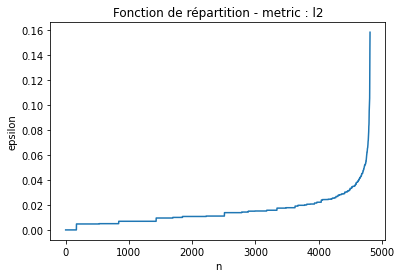

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.044261   0.04671994 0.04917889 0.05163783 0.05409678]
silhouette : -0.807257112512155, calinski : 21.232174934841833, DB : 1.1652167783567013, time : 0.015891075134277344, clusters : 198
silhouette : -0.3496590162388902, calinski : 288.77682308121274, DB : 2.3447348115031565, time : 0.019118785858154297, clusters : 30
silhouette : -0.01757393979269053, calinski : 314.92541160984695, DB : 1.4466159248979327, time : 0.019067049026489258, clusters : 23
silhouette : -0.10570590841548244, calinski : 283.10258911828157, DB : 1.3968514304099975, time : 0.013250112533569336, clusters : 30
silhouette : -0.1917552298271041, calinski : 155.64679871360377, DB : 1.2158831470528284, time : 0.012760639190673828, clusters : 33
silhouette : -0.8179985740710636, calinski : 25.32114799035825, DB : 1.1897764380899

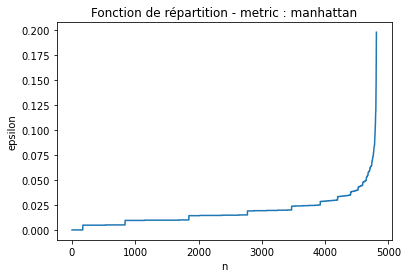

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.05637143 0.05950317 0.06263492 0.06576667 0.06889841]
silhouette : -0.8105933745073379, calinski : 22.565459473500496, DB : 1.1590669010128445, time : 0.020467519760131836, clusters : 184
silhouette : -0.3810513203237357, calinski : 215.67407421856777, DB : 1.7546140981279064, time : 0.02160501480102539, clusters : 16
silhouette : 0.0024029408487256368, calinski : 327.22794417834757, DB : 1.3879484646524793, time : 0.014601945877075195, clusters : 24
silhouette : -0.09652879038760265, calinski : 280.48272034524035, DB : 1.2288221311016003, time : 0.014546871185302734, clusters : 36
silhouette : -0.20589307946817287, calinski : 187.1549000131834, DB : 1.2145437496059608, time : 0.020898103713989258, clusters : 31
silhouette : -0.815427144015477, calinski : 27.05905953192692, DB : 1.169686

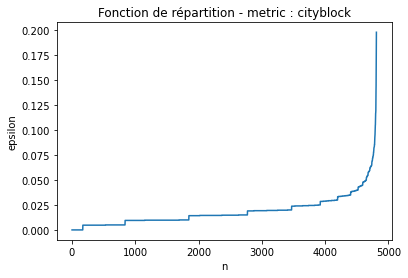

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.05637143 0.05950317 0.06263492 0.06576667 0.06889841]
silhouette : -0.8105933745073379, calinski : 22.565459473500496, DB : 1.1590669010128445, time : 0.015247821807861328, clusters : 184
silhouette : -0.3810513203237357, calinski : 215.67407421856777, DB : 1.7546140981279064, time : 0.021658897399902344, clusters : 16
silhouette : 0.0024029408487256368, calinski : 327.22794417834757, DB : 1.3879484646524793, time : 0.021738290786743164, clusters : 24
silhouette : -0.09652879038760265, calinski : 280.48272034524035, DB : 1.2288221311016003, time : 0.022435665130615234, clusters : 36
silhouette : -0.20589307946817287, calinski : 187.1549000131834, DB : 1.2145437496059608, time : 0.022081613540649414, clusters : 31
silhouette : -0.815427144015477, calinski : 27.05905953192692, DB : 1.16968

In [186]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"banana.arff", 
                                               params_eps={"n":5, "window":0.1,"center":0.98},
                                                params_min_pts={'n':5, 'min':1, 'max':15})

In [187]:
best_params

{'CAL': (array([4, 4]), array([2, 2]), array([0, 2])),
 'SILH': (array([4, 4]), array([2, 2]), array([0, 2])),
 'DB': (array([1, 1, 1]), array([4, 4, 4]), array([1, 3, 4]))}

In [188]:
EPS

{'euclidean': array([0.044261  , 0.04671994, 0.04917889, 0.05163783, 0.05409678]),
 'l1': array([0.05637143, 0.05950317, 0.06263492, 0.06576667, 0.06889841]),
 'l2': array([0.044261  , 0.04671994, 0.04917889, 0.05163783, 0.05409678]),
 'manhattan': array([0.05637143, 0.05950317, 0.06263492, 0.06576667, 0.06889841]),
 'cityblock': array([0.05637143, 0.05950317, 0.06263492, 0.06576667, 0.06889841])}

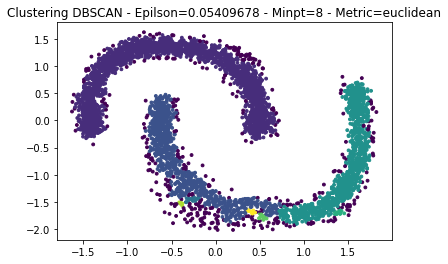

Estimated number of clusters: 8
Estimated number of noise points: 397
coefficient de silhouette: 0.054968
coefficient de calinsky: 788.702086
coefficient de Davies Bouldin: 1.890944
Running time: 0.013248


In [189]:
doDBSCAN(path+"banana.arff",0.05409678,8,'euclidean')

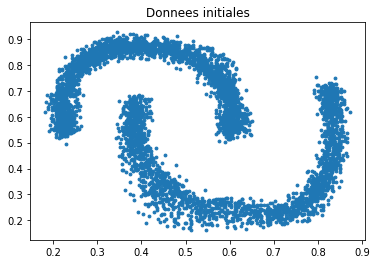

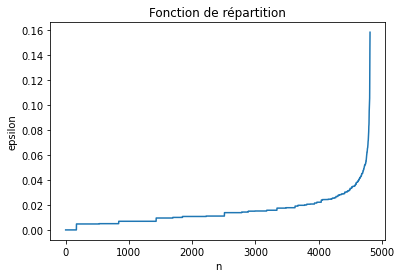

Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


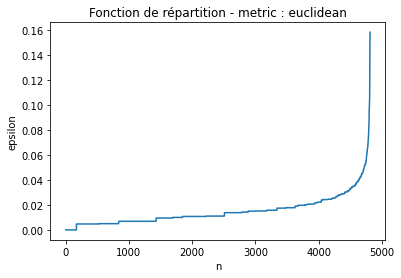

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.14234996 0.15025829 0.15816662 0.16607495 0.17398328]
silhouette : -0.1055282085877357, calinski : 911.7327914564621, DB : 1.4558307676422895, time : 0.03342413902282715, clusters : 5
silhouette : 0.21381185816379464, calinski : 1821.3391551292887, DB : 4.704971006496028, time : 0.02927541732788086, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.020734548568725586, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.02365589141845703, clusters : 2
silhouette : 0.2149583360342756, calinski : 1824.063982496904, DB : 2.1618294294418203, time : 0.021259784698486328, clusters : 2
silhouette : 0.005063512394445574, calinski : 1214.182180572074, DB : 1.6587217627094815, tim

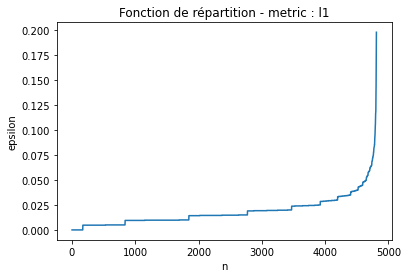

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : 0.005063512394445574, calinski : 1214.182180572074, DB : 1.6587217627094815, time : 0.03121042251586914, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.02349853515625, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.026340961456298828, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.024517059326171875, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.023592710494995117, clusters : 2
silhouette : 0.0701703304871724, calinski : 1821.3700331259015, DB : 1.4732789371760127, time : 0.0

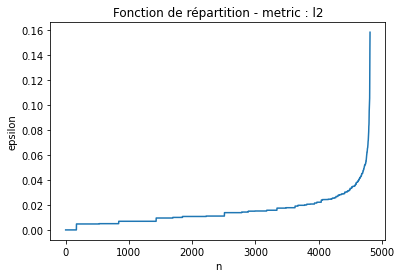

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.14234996 0.15025829 0.15816662 0.16607495 0.17398328]
silhouette : -0.1055282085877357, calinski : 911.7327914564621, DB : 1.4558307676422895, time : 0.027161359786987305, clusters : 5
silhouette : 0.21381185816379464, calinski : 1821.3391551292887, DB : 4.704971006496028, time : 0.02476978302001953, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.02037334442138672, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.025141000747680664, clusters : 2
silhouette : 0.2149583360342756, calinski : 1824.063982496904, DB : 2.1618294294418203, time : 0.020346641540527344, clusters : 2
silhouette : 0.005063512394445574, calinski : 1214.182180572074, DB : 1.6587217627094815, time : 0.

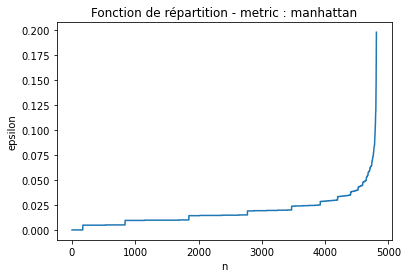

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : 0.005063512394445574, calinski : 1214.182180572074, DB : 1.6587217627094815, time : 0.028026580810546875, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.02418208122253418, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.023401975631713867, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.02368617057800293, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.023215770721435547, clusters : 2
silhouette : 0.0701703304871724, calinski : 1821.3700331259015, DB : 1.4732789371760127, 

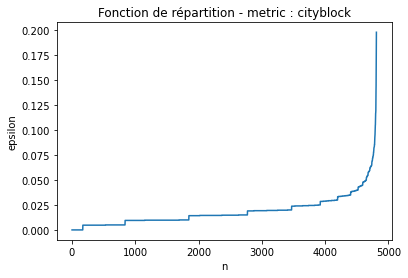

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : 0.005063512394445574, calinski : 1214.182180572074, DB : 1.6587217627094815, time : 0.02742481231689453, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.024662494659423828, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.023537158966064453, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.023128271102905273, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.02325296401977539, clusters : 2
silhouette : 0.0701703304871724, calinski : 1821.3700331259015, DB : 1.4732789371760127, 

In [190]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"banana.arff", 
                                               params_eps={"n":5, "window":0.1,"center":1},
                                                params_min_pts={'n':5, 'min':1, 'max':15})

In [191]:
best_params

{'CAL': (array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
         2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
         2, 3, 4, 0, 1, 2, 3, 4])),
 'SILH': (array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,

In [192]:
EPS

{'euclidean': array([0.14234996, 0.15025829, 0.15816662, 0.16607495, 0.17398328]),
 'l1': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127]),
 'l2': array([0.14234996, 0.15025829, 0.15816662, 0.16607495, 0.17398328]),
 'manhattan': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127]),
 'cityblock': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127])}

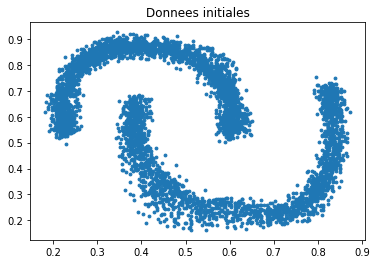

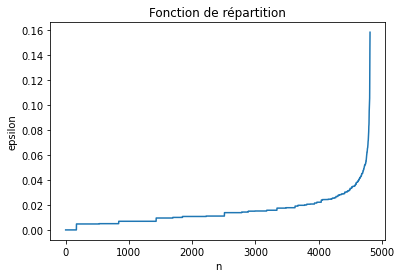

Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
Paramètres 'min_pts' testés : [ 1.   4.5  8.  11.5 15. ]


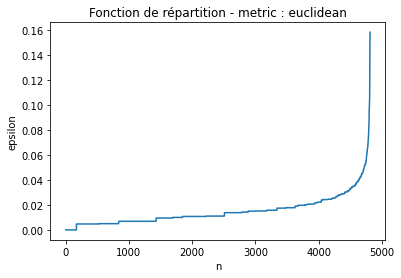

########## METRIC - euclidean - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.14234996 0.15025829 0.15816662 0.16607495 0.17398328]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.02533102035522461, clusters : 5
silhouette : 0.21381185816379464, calinski : 1821.3391551292887, DB : 4.704971006496028, time : 0.023602008819580078, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.024473190307617188, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.0207369327545166, clusters : 2
silhouette : 0.2149583360342756, calinski : 1824.063982496904, DB : 2.1618294294418203, time : 0.022286415100097656, clusters : 2
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.023999691009521484, clusters : 4
silhouette : 0.0953652279386283, cal

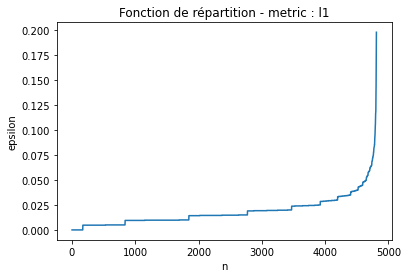

########## METRIC - l1 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.03765225410461426, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.03536868095397949, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.03112483024597168, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.024671554565429688, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.024127721786499023, clusters : 2
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.023831844329833984, clusters : 3
silhouette : 0.15947793018087952, calinsk

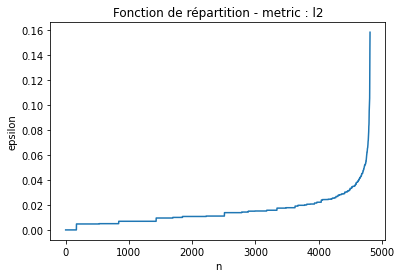

########## METRIC - l2 - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.15816661875132032 
[0.14234996 0.15025829 0.15816662 0.16607495 0.17398328]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.0233306884765625, clusters : 5
silhouette : 0.21381185816379464, calinski : 1821.3391551292887, DB : 4.704971006496028, time : 0.023715496063232422, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.020241975784301758, clusters : 2
silhouette : 0.21729225390735477, calinski : 1822.9641200543274, DB : 2.486840311502819, time : 0.021248817443847656, clusters : 2
silhouette : 0.2149583360342756, calinski : 1824.063982496904, DB : 2.1618294294418203, time : 0.024992942810058594, clusters : 2
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.028385162353515625, clusters : 4
silhouette : 0.0953652279386283, calinski 

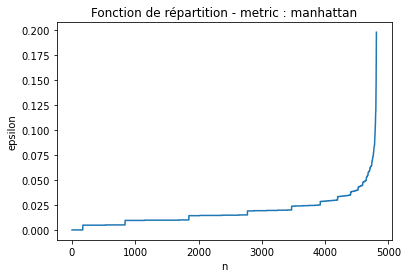

########## METRIC - manhattan - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.03339433670043945, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.02624821662902832, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.023308515548706055, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.028547286987304688, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.023288488388061523, clusters : 2
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.02499842643737793, clusters : 3
silhouette : 0.15947793018087952, 

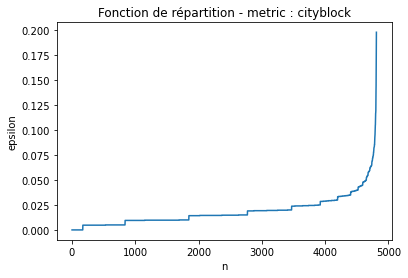

########## METRIC - cityblock - ##############
Distance minimale entre un échantillon et son premier voisin : 0.0 
Distance maximale entre un échantillon et son premier voisin : 0.19820115776640154 
[0.17838104 0.1882911  0.19820116 0.20811122 0.21802127]
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.02825021743774414, clusters : 4
silhouette : 0.14574669970068752, calinski : 1822.7544482579538, DB : 1.6139207819011194, time : 0.027239084243774414, clusters : 2
silhouette : 0.15441168934806676, calinski : 1824.0465192828037, DB : 1.4679538379792352, time : 0.02725982666015625, clusters : 2
silhouette : 0.16838131259739586, calinski : 1825.556010574001, DB : 1.384532651850149, time : 0.02708292007446289, clusters : 2
silhouette : 0.1733616452805988, calinski : 1827.0350806037259, DB : 1.3162402400969764, time : 0.027531147003173828, clusters : 2
silhouette : -10000, calinski : -10000, DB : 10000, time : 0.028247594833374023, clusters : 3
silhouette : 0.15947793018087952, 

In [193]:
eval_params, best_params, EPS=bestConfigDBSCAN(path+"banana.arff", 
                                               params_eps={"n":5, "window":0.1,"center":1},
                                                params_min_pts={'n':5, 'min':1, 'max':15}, cluster_filter=2)

In [194]:
best_params

{'CAL': (array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
         2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
         2, 3, 4, 0, 1, 2, 3, 4])),
 'SILH': (array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]),
  array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3]),
  array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,

In [195]:
EPS

{'euclidean': array([0.14234996, 0.15025829, 0.15816662, 0.16607495, 0.17398328]),
 'l1': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127]),
 'l2': array([0.14234996, 0.15025829, 0.15816662, 0.16607495, 0.17398328]),
 'manhattan': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127]),
 'cityblock': array([0.17838104, 0.1882911 , 0.19820116, 0.20811122, 0.21802127])}

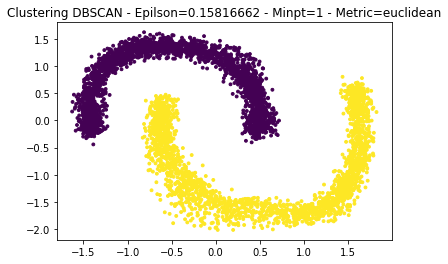

Estimated number of clusters: 2
Estimated number of noise points: 0
coefficient de silhouette: 0.363263
coefficient de calinsky: 3642.725339
coefficient de Davies Bouldin: 1.115167
Running time: 0.023289


In [196]:
doDBSCAN(path+"banana.arff",0.15816662,1,'euclidean')